# AI vs Human — Full Workflow

> Steps:
> 1) **EDA**
> 2) **Data Cleaning**
> 3) **Visualization**
> 4) **Modeling**


#  Extracted Features (from text content)

| Feature               | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| **word_count**         | Number of words in the text.                                               |
| **character_count**    | Number of characters in the text.                                          |
| **sentence_count**     | Number of sentences in the text.                                           |
| **avg_sentence_length**| Average sentence length (in words).                                        |
| **avg_word_length**    | Average word length (in characters).                                       |
| **lexical_diversity**  | Ratio of unique words to total words.                                      |
| **punctuation_ratio**  | Proportion of punctuation marks relative to total characters.              |
| **flesch_reading_ease**| Readability score (higher = easier to read).                               |
| **gunning_fog_index**  | Fog Index readability measure (higher = harder to read).                   |
| **grammar_errors**     | Count/ratio of grammatical errors.                                         |
| **passive_voice_ratio**| Ratio of passive voice sentences.                                          |
| **predictability_score**| Measure of how predictable/repetitive the text is.                        |
| **burstiness**         | Variation in sentence length (consistency vs. spikes).                     |
| **sentiment_score**    | Sentiment polarity (positive / negative).                                  |
| **label**              | Original class (AI / Human).                                               |
| **label_bin**          | Numeric version of class (0 = AI, 1 = Human).                              |


# AI vs Human — Feature Comparison

## Mean Values per Feature

| Feature              | Human_mean | AI_mean | AI_minus_Human | Higher |
|-----------------------|-----------:|--------:|---------------:|:-------|
| **word_count**        | 137.537    | 142.849 | +5.313         | AI     |
| **burstiness**        | 0.442      | 0.412   | -0.031         | Human  |
| **avg_sentence_length**| 5.499      | 5.473   | -0.026         | Human  |
| **gunning_fog_index** | 7.549      | 7.565   | +0.016         | AI     |
| **avg_word_length**   | 5.714      | 5.721   | +0.007         | AI     |
| **lexical_diversity** | 0.969      | 0.967   | -0.002         | Human  |
| **passive_voice_ratio**| 0.150     | 0.151   | +0.001         | AI     |
| **flesch_reading_ease**| 52.184    | 52.183  | -0.001         | Human  |
| **punctuation_ratio** | 0.027      | 0.027   | +0.000         | AI     |

---

## Key Insights

1. **Word Count**  
   - AI texts are slightly longer on average (+5 words).  
   - Biggest gap compared to other features.  

2. **Burstiness & Sentence Length**  
   - Humans show higher burstiness (mix of short/long sentences).  
   - Sentence length is also slightly more varied in Human writing.  

3. **Readability (Flesch & Fog Index)**  
   - Both are very close, but:  
     - AI has a slightly higher **Fog Index** → text is a bit more complex.  
     - Human has marginally higher **Flesch Reading Ease** → easier to read.  

4. **Vocabulary**  
   - Human texts have marginally higher **lexical diversity** (unique words).  
   - AI repeats words slightly more often.  

5. **Style (Word Length, Passive Voice, Punctuation)**  
   - Very similar across both groups.  
   - AI tends to use slightly longer words and marginally more passive voice.  

---

## Overall
- **Biggest discriminator:** `word_count` (AI writes longer).  
- **Subtle signals favoring Human:** `burstiness`, `sentence_length`, `lexical_diversity`.  
- **Subtle signals favoring AI:** `fog_index`, `avg_word_length`, `passive_voice_ratio`.  
- **Neutral:** `punctuation_ratio`, `flesch_reading_ease`.  

This suggests **AI is more consistent and slightly more complex**, while **Human writing is more varied and diverse**.


In [8]:
from collections import Counter
import pandas as pd
# --- Standard Library
import os
import re
import sys
import json
import string

# --- Scientific & Data Handling
import numpy as np
import pandas as pd
from scipy import stats

# --- Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# --- NLP
from nltk.corpus import stopwords

# --- ML & Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# --- Persistence
from joblib import dump

# NLTK stopwords 
import nltk
try:
    _ = nltk.corpus.stopwords.words("english")
except LookupError:
    nltk.download("stopwords")

sns.set(rc={"figure.figsize": (8,5)})
pd.set_option("display.max_colwidth", 200)


In [2]:
# === CONFIG ===
DATA_PATH ="ai_human_content_detection_dataset.csv" 
TEXT_COL  = "text_content"       
LABEL_COL = "label"                


## 1) EDA —  

In [4]:

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (1367, 17)
Columns: ['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label']


text_content      content_type  \
0  Score each cause. Quality throughout beautiful...    academic_paper   
1  Board its rock. Job worker break tonight coupl...             essay   
2  Way debate decision produce. Dream necessary c...    academic_paper   
3  Story turn because such during open model. Tha...  creative_writing   
4  Place specific as simply leader fall analysis....      news_article   

   word_count  character_count  sentence_count  lexical_diversity  \
0         288             1927              54             0.9514   
1         253             1719              45             0.9723   
2         420             2849              75             0.9071   
3         196             1310              34             0.9592   
4         160             1115              28             0.9688   

   avg_sentence_length  avg_word_length  punctuation_ratio  \
0                 5.33             5.69             0.0280   
1                 5.62             5.80             0.0262   
2                 5.60             5.79             0.0263   
3                 5.76             5.69             0.0260   
4                 5.71             5.97             0.0251   

   flesch_reading_ease  gunning_fog_index  grammar_errors  \
0                53.08               7.41               1   
1                50.32               8.10               6   
2                46.86               7.86               5   
3                53.80               7.00               2   
4                44.53               8.29               0   

   passive_voice_ratio  predictability_score  burstiness  sentiment_score  \
0               0.1041                105.86      0.5531           0.2034   
1               0.2045                100.29      0.5643           0.4854   
2               0.2308                 96.88      0.4979          -0.2369   
3               0.1912                 88.79      0.6241              NaN   
4               0.1318                 26.15      0.2894              NaN   

   label  
0      1  
1      1  
2      1  
3      1  
4      1

In [5]:
# ---- Robust column setup 
TEXT_COL = "text_content"
LABEL_COL = "label_bin" if "label_bin" in df.columns else "label"

# Sanity checks
for c in [TEXT_COL, LABEL_COL]:
    if c not in df.columns:
        raise ValueError(f"Required column '{c}' is missing from the DataFrame.")

# If LABEL_COL is 'label' and it's not numeric, try to normalize to 0/1
if LABEL_COL == "label" and df[LABEL_COL].dtype == "O":
    def normalize_label(v):
        s = str(v).strip().lower()
        if s in ["ai", "gpt", "machine", "generated"]:
            return 1
        if s in ["human", "person", "real"]:
            return 0
        return np.nan
    df["label_bin"] = df[LABEL_COL].apply(normalize_label)
    LABEL_COL = "label_bin"

# Coerce types & drop null labels
df[TEXT_COL] = df[TEXT_COL].astype(str)
df = df.dropna(subset=[TEXT_COL, LABEL_COL])

print("TEXT_COL:", TEXT_COL, "| LABEL_COL:", LABEL_COL)
print(df[[TEXT_COL, LABEL_COL]].head(3))


TEXT_COL: text_content | LABEL_COL: label
                                        text_content  label
0  Score each cause. Quality throughout beautiful...      1
1  Board its rock. Job worker break tonight coupl...      1
2  Way debate decision produce. Dream necessary c...      1


In [6]:
# Normalize labels to 0/1 (Human=0, AI=1) if string
def normalize_label(v):
    if isinstance(v, str):
        s = v.strip().lower()
        if s in ["ai", "gpt", "machine", "generated"]:
            return 1
        if s in ["human", "person", "real"]:
            return 0
    return v

y_raw = df[LABEL_COL].apply(normalize_label)

# If still strings / mixed, try factorize
if y_raw.dtype == "O":
    codes, uniques = pd.factorize(y_raw)
    print("Label classes (factorized):", list(uniques))
    y = pd.Series(codes, index=df.index)
else:
    y = y_raw.astype(int)

df["label_bin"] = y
df["label_bin"].value_counts(dropna=False)


label_bin
0    684
1    683
Name: count, dtype: int64

C:\Users\rmutairi\AppData\Local\Temp\ipykernel_32704\3882222469.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Human (0)", "AI (1)"])


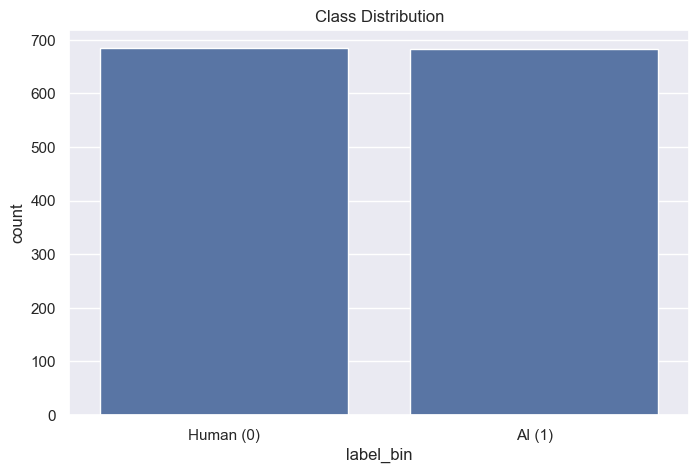

Counts:
 label_bin
0    684
1    683
Name: count, dtype: int64
Proportions:
 label_bin
0    0.500366
1    0.499634
Name: proportion, dtype: float64


In [9]:
# Class distribution
ax = sns.countplot(x="label_bin", data=df)
ax.set_xticklabels(["Human (0)", "AI (1)"])
ax.set_title("Class Distribution")
plt.show()

print("Counts:\n", df["label_bin"].value_counts())
print("Proportions:\n", df["label_bin"].value_counts(normalize=True))


C:\Users\rmutairi\AppData\Local\Temp\ipykernel_32704\1678875995.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Human (0)", "AI (1)"])


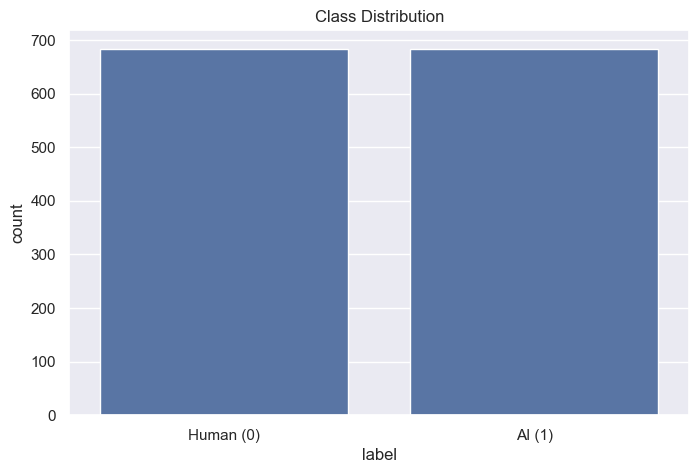

Counts:
 label
0    684
1    683
Name: count, dtype: int64
Proportions:
 label
0    0.500366
1    0.499634
Name: proportion, dtype: float64


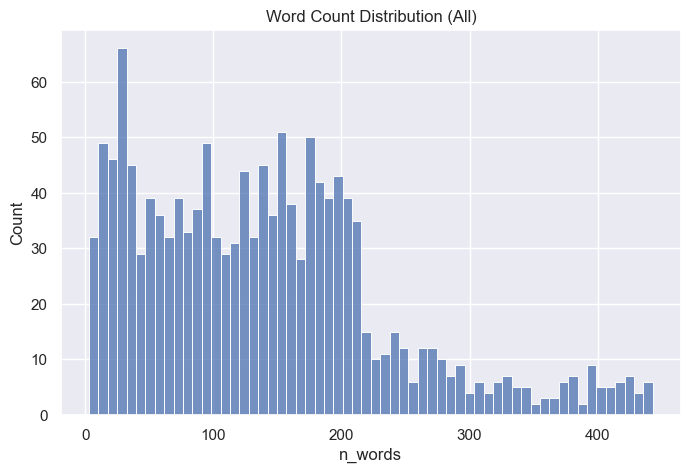

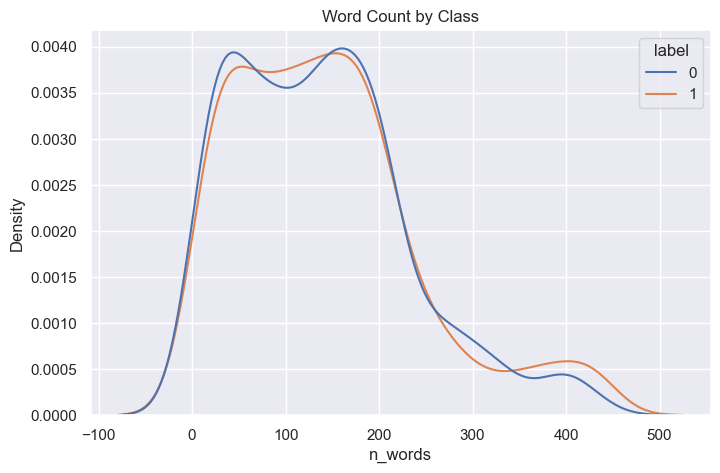

n_words                                                 n_chars          \
        count    mean     std  min   25%    50%    75%    max   count    mean   
label                                                                           
0       684.0  137.54   94.61  3.0  58.0  131.0  192.0  438.0   684.0  921.57   
1       683.0  142.85  100.13  3.0  64.0  130.0  193.0  443.0   683.0  959.11   

                                                    
          std   min     25%    50%     75%     max  
label                                               
0      635.12  27.0  397.25  881.0  1279.0  2889.0  
1      672.97  14.0  421.00  882.0  1301.5  2966.0

In [10]:
sns.set(rc={"figure.figsize": (8,5)})

# 1) Class balance
ax = sns.countplot(x=LABEL_COL, data=df)
ax.set_xticklabels(["Human (0)", "AI (1)"])
ax.set_title("Class Distribution")
plt.show()
print("Counts:\n", df[LABEL_COL].value_counts())
print("Proportions:\n", df[LABEL_COL].value_counts(normalize=True))

# 2) Length features: prefer your existing columns; fallback if missing
if "word_count" in df.columns:
    df["n_words"] = df["word_count"]
else:
    df["n_words"] = df[TEXT_COL].apply(lambda x: len(x.split()))

if "character_count" in df.columns:
    df["n_chars"] = df["character_count"]
else:
    df["n_chars"] = df[TEXT_COL].apply(len)

# Distributions
sns.histplot(df["n_words"], bins=60)
plt.title("Word Count Distribution (All)")
plt.show()

sns.kdeplot(data=df, x="n_words", hue=LABEL_COL, common_norm=False)
plt.title("Word Count by Class")
plt.show()

# Quick group stats
display(df[["n_words", "n_chars", LABEL_COL]].groupby(LABEL_COL).describe().round(2))


In [11]:

STOPWORDS = set(stopwords.words("english"))
URL_RE = re.compile(r'https?://\S+|www\.\S+')
HTML_RE = re.compile(r'<.*?>')

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    # Optional stopword removal:
    tokens = [w for w in s.split() if w not in STOPWORDS]
    return " ".join(tokens)

df["text_clean"] = df[TEXT_COL].apply(clean_text)

# Optional: remove duplicates of cleaned text
before = len(df)
df = df.drop_duplicates(subset=["text_clean"])
print("Removed duplicates:", before - len(df))
df[["text_content", "text_clean", LABEL_COL]].head(3)


Removed duplicates: 0


text_content  \
0  Score each cause. Quality throughout beautiful instead.\nDespite measure ago current.\nDetermine operation speak according south recently. Everyone democratic shake bill here grow. Page southern r...   
1  Board its rock. Job worker break tonight couple and.\nMind southern rather. Hair attorney professional form finish. Rest feel finally impact.\nNever court professor here security. Past feeling nat...   
2  Way debate decision produce. Dream necessary choose impact. Like allow explain executive teacher author do enough. Operation sound cup boy different chance enter central.\nSociety organization sta...   

                                                                                                                                                                                                text_clean  \
0  score cause quality throughout beautiful instead despite measure ago current determine operation speak according south recently everyone democratic shake bill grow page southern role movie win sto...   
1  board rock job worker break tonight couple mind southern rather hair attorney professional form finish rest feel finally impact never court professor security past feeling nature decision size par...   
2  way debate decision produce dream necessary choose impact like allow explain executive teacher author enough operation sound cup boy different chance enter central society organization station tv ...   

   label  
0      1  
1      1  
2      1

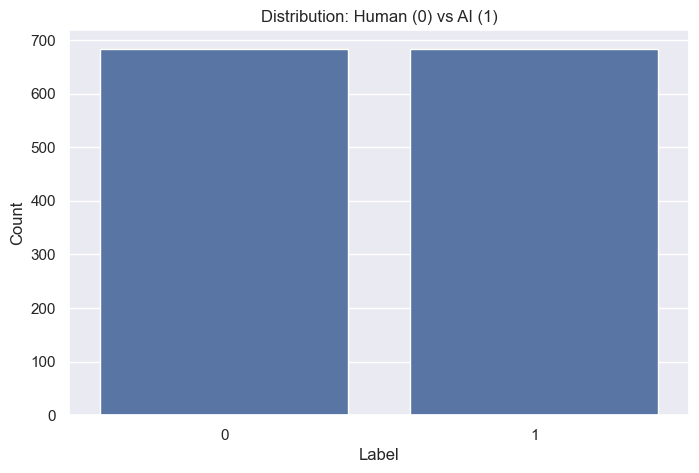

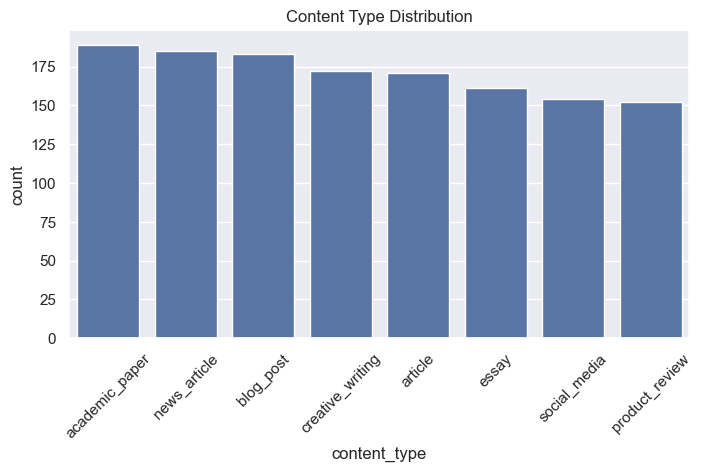

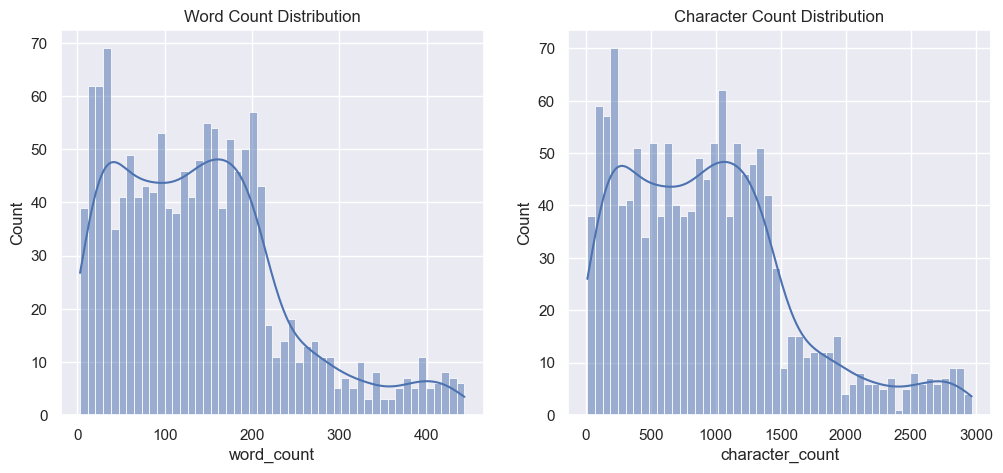

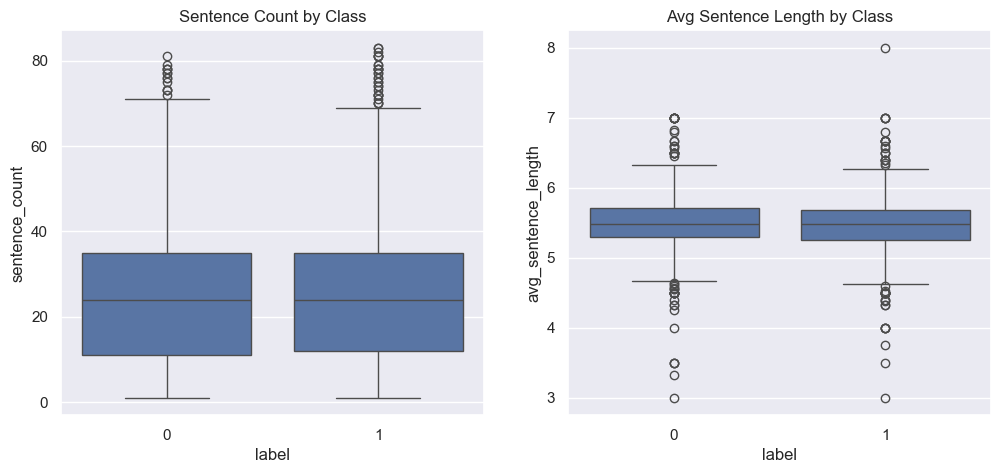

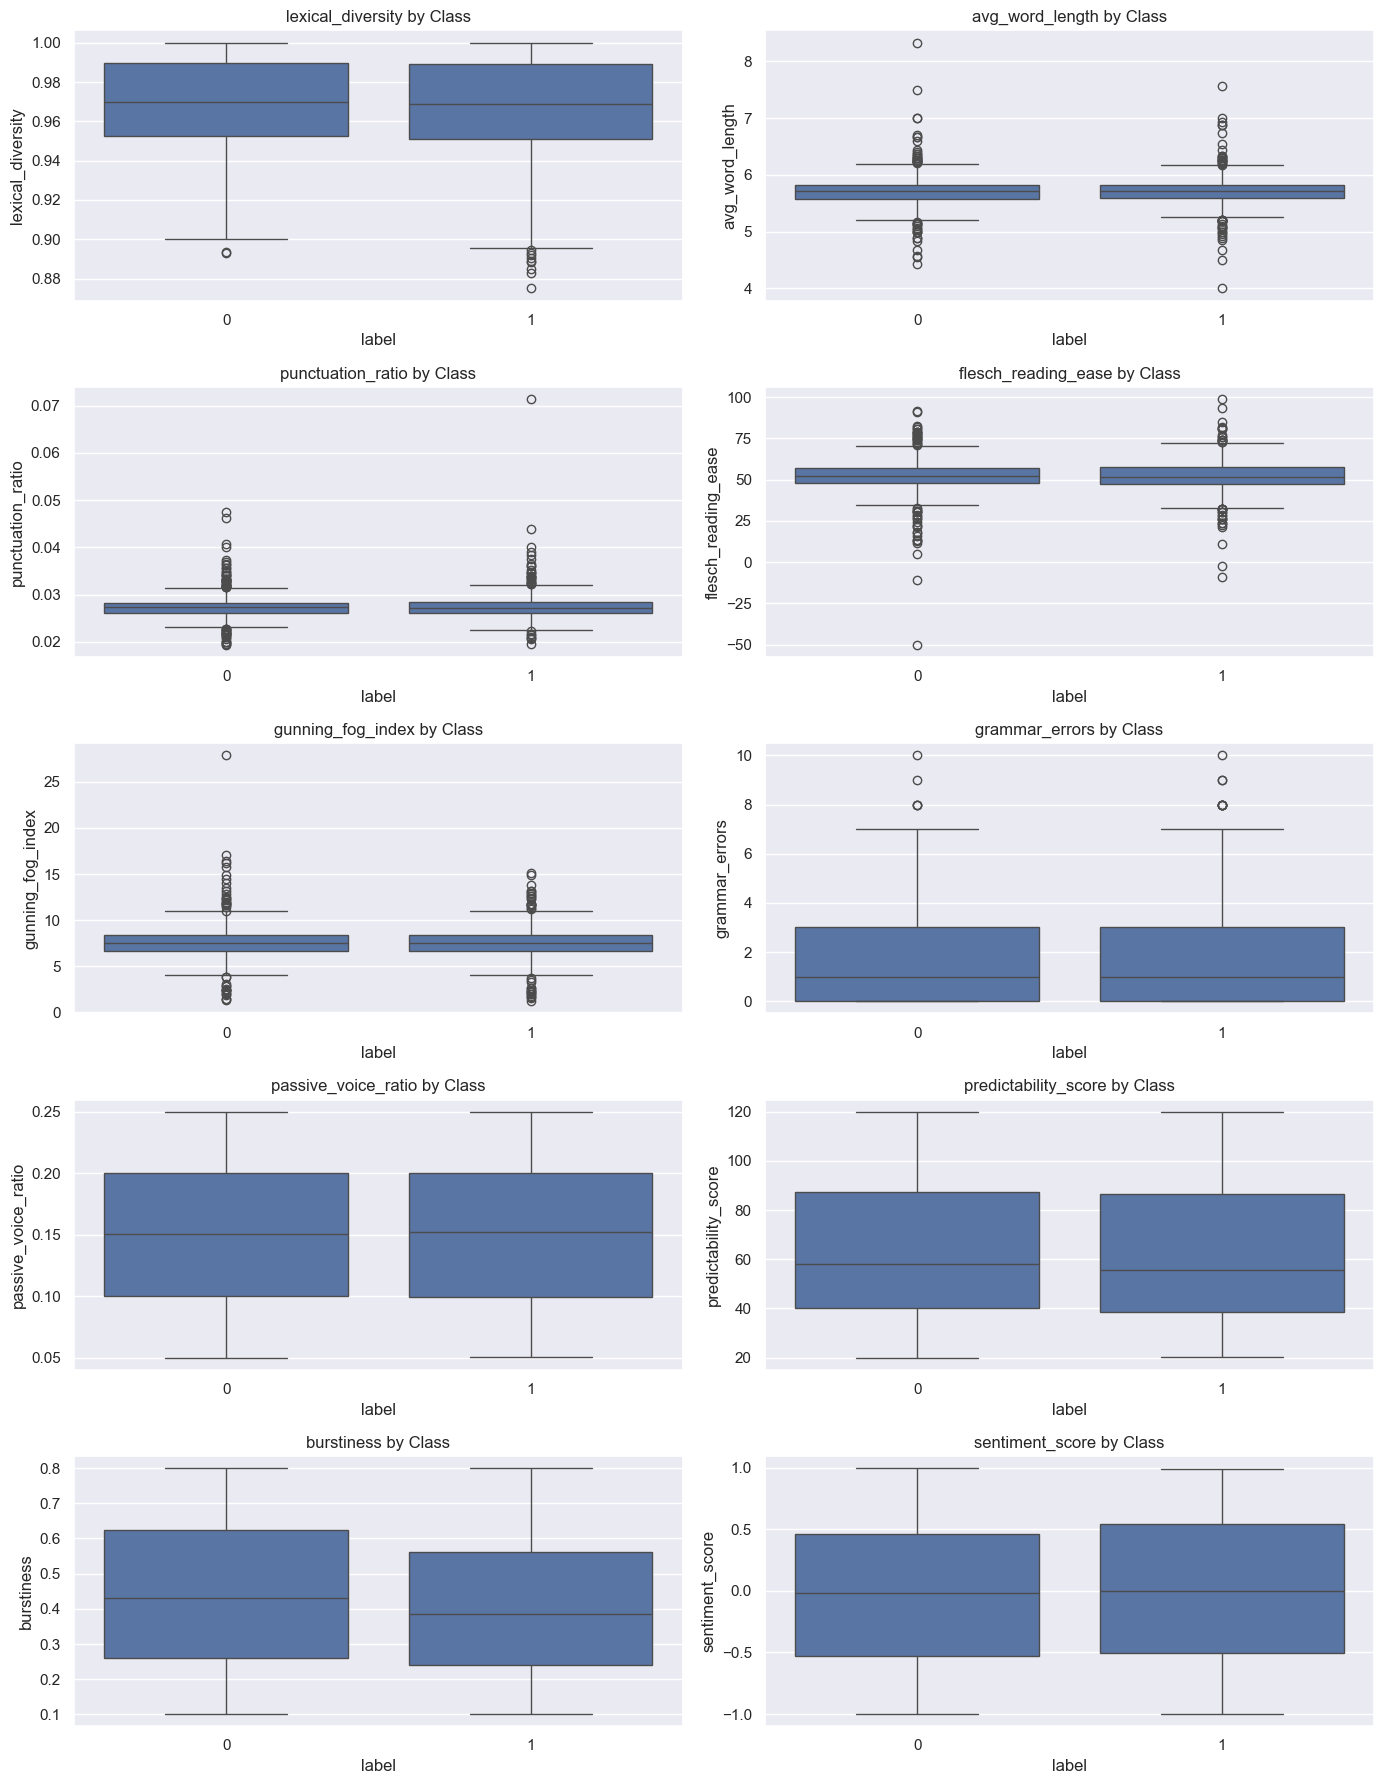

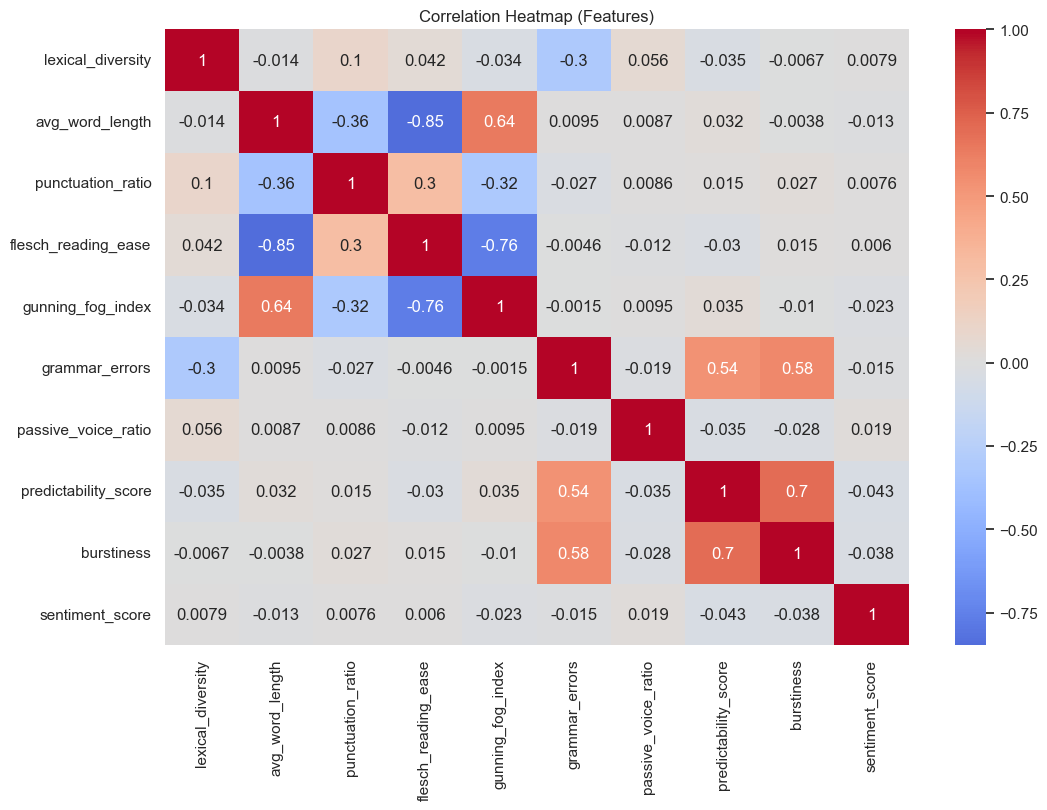

In [12]:

plt.figure()
sns.countplot(x="label", data=df)
plt.title("Distribution: Human (0) vs AI (1)")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
sns.countplot(x="content_type", data=df, order=df["content_type"].value_counts().index)
plt.title("Content Type Distribution")
plt.xticks(rotation=45)
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.histplot(df["word_count"], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Word Count Distribution")
sns.histplot(df["character_count"], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Character Count Distribution")
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.boxplot(x="label", y="sentence_count", data=df, ax=axes[0])
axes[0].set_title("Sentence Count by Class")
sns.boxplot(x="label", y="avg_sentence_length", data=df, ax=axes[1])
axes[1].set_title("Avg Sentence Length by Class")
plt.show()

features = ["lexical_diversity","avg_word_length","punctuation_ratio",
            "flesch_reading_ease","gunning_fog_index","grammar_errors",
            "passive_voice_ratio","predictability_score","burstiness","sentiment_score"]

fig, axes = plt.subplots(len(features)//2, 2, figsize=(14,18))
axes = axes.flatten()

for i, feat in enumerate(features):
    sns.boxplot(x="label", y=feat, data=df, ax=axes[i])
    axes[i].set_title(f"{feat} by Class")

plt.tight_layout()
plt.show()

plt.figure(figsize=(12,8))
corr = df[features].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Features)")
plt.show()


## 2) Data Cleaning — 

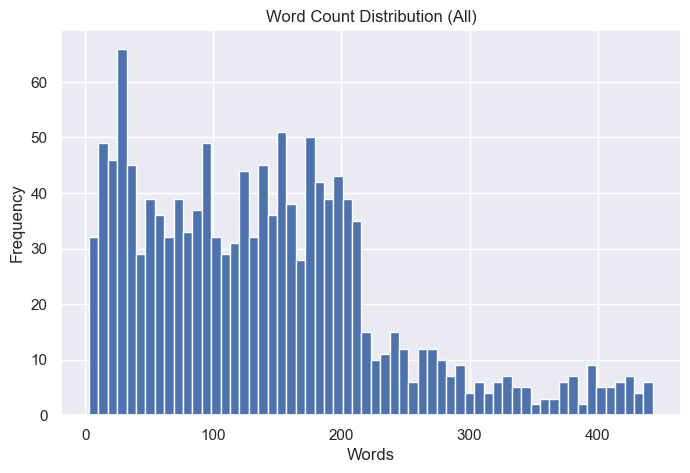

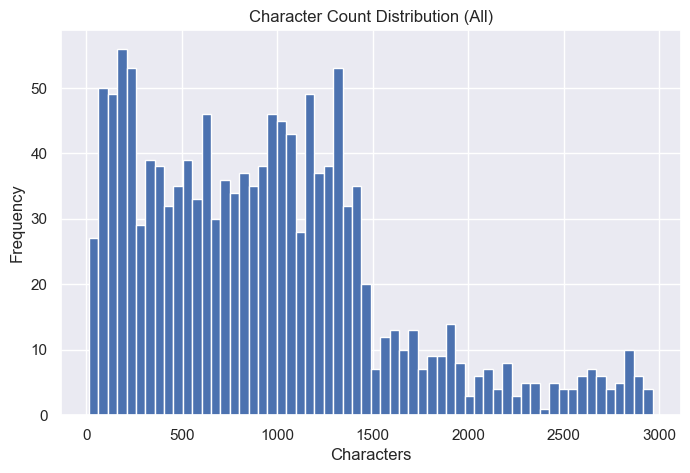

In [13]:
# Make sure counts exist (fallbacks if missing)
if "word_count" not in df.columns:
    df["word_count"] = df["text_content"].astype(str).apply(lambda x: len(x.split()))
if "character_count" not in df.columns:
    df["character_count"] = df["text_content"].astype(str).apply(len)

# Word count (all)
plt.figure()
plt.hist(df["word_count"].values, bins=60)
plt.title("Word Count Distribution (All)")
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.show()

# Character count (all)
plt.figure()
plt.hist(df["character_count"].values, bins=60)
plt.title("Character Count Distribution (All)")
plt.xlabel("Characters")
plt.ylabel("Frequency")
plt.show()


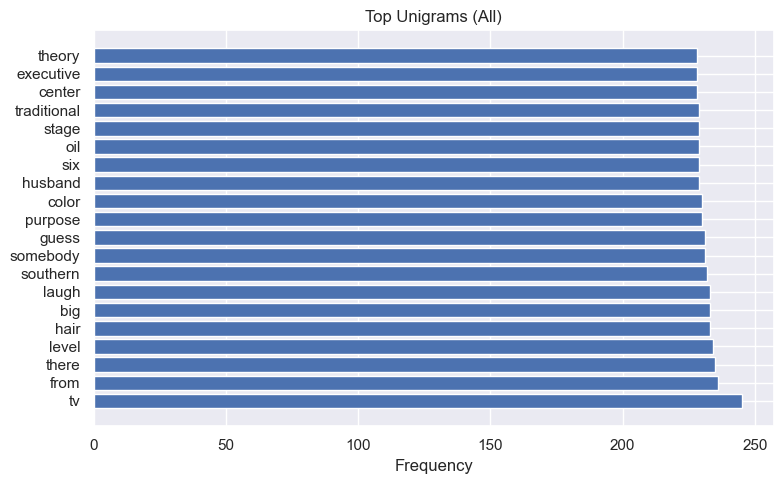

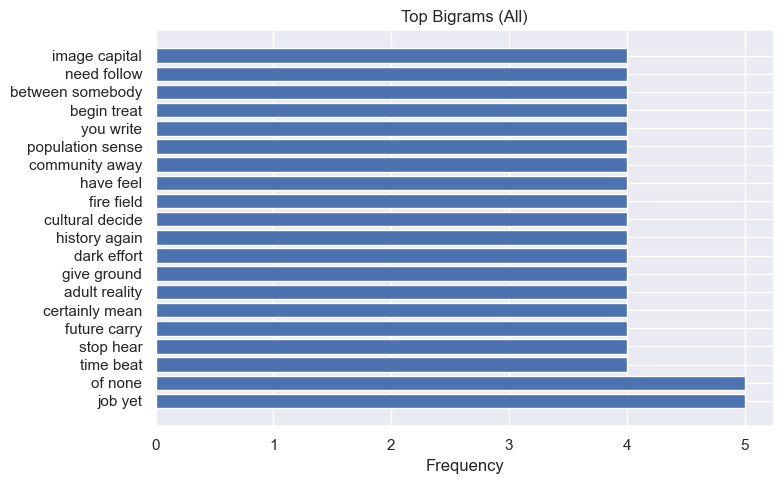

In [14]:
from sklearn.feature_extraction.text import CountVectorizer

texts = df["text_content"].astype(str).values

def plot_top_ngrams(corpus, ngram_range=(1,1), topk=20, title="Top n-grams"):
    vec = CountVectorizer(ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(corpus)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())

    order = np.argsort(-sums)[:topk]
    top_terms = terms[order]
    top_counts = sums[order]

    # Horizontal bar
    y_pos = np.arange(len(top_terms))[::-1]
    plt.figure()
    plt.barh(y_pos, top_counts[::-1])
    plt.yticks(y_pos, top_terms[::-1])
    plt.title(title)
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

# Unigrams & bigrams (all texts)
plot_top_ngrams(texts, (1,1), 20, "Top Unigrams (All)")
plot_top_ngrams(texts, (2,2), 20, "Top Bigrams (All)")


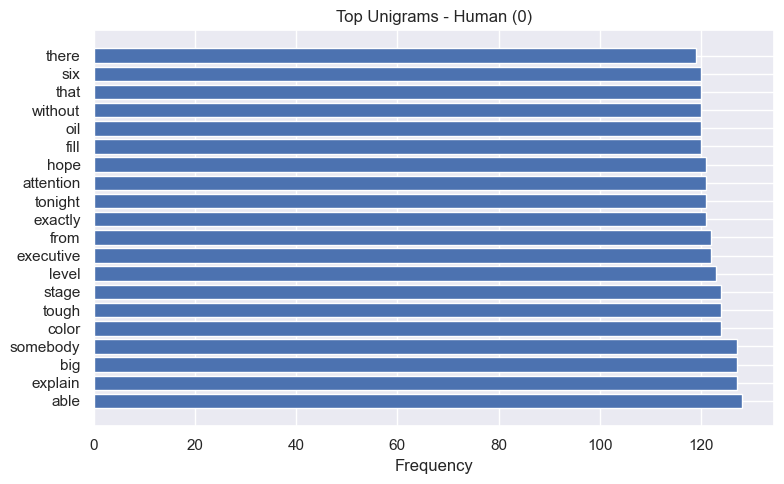

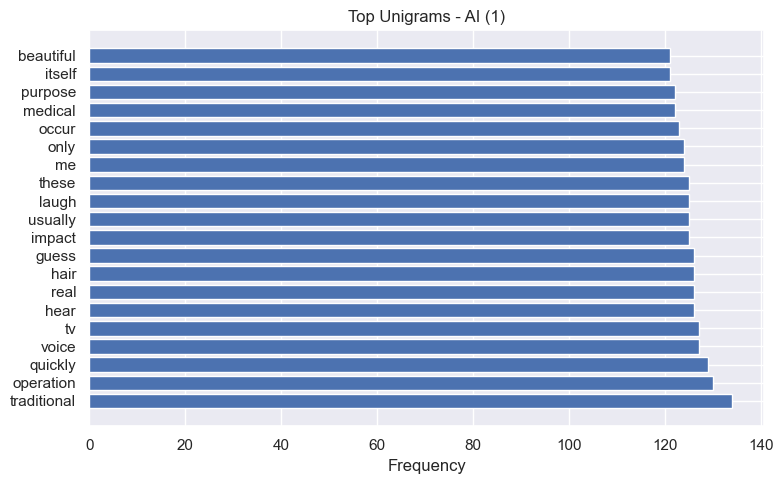

In [15]:
def top_ngrams_per_class(df, label_value, ngram_range=(1,1), topk=20):
    sub = df.loc[df["label_bin"]==label_value, "text_content"].astype(str).values
    if len(sub) == 0:
        print(f"No samples for class {label_value}")
        return
    vec = CountVectorizer(ngram_range=ngram_range, min_df=2)
    X = vec.fit_transform(sub)
    sums = np.asarray(X.sum(axis=0)).ravel()
    terms = np.array(vec.get_feature_names_out())

    order = np.argsort(-sums)[:topk]
    top_terms = terms[order]
    top_counts = sums[order]

    y_pos = np.arange(len(top_terms))[::-1]
    plt.figure()
    plt.barh(y_pos, top_counts[::-1])
    cls_name = "Human (0)" if label_value==0 else "AI (1)"
    plt.yticks(y_pos, top_terms[::-1])
    plt.title(f"Top Unigrams - {cls_name}")
    plt.xlabel("Frequency")
    plt.tight_layout()
    plt.show()

top_ngrams_per_class(df, 0, (1,1), 20)
top_ngrams_per_class(df, 1, (1,1), 20)


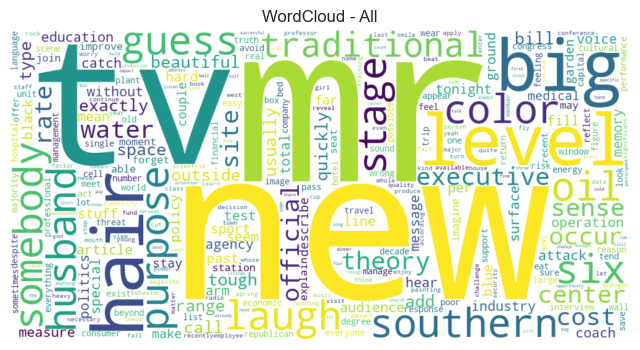

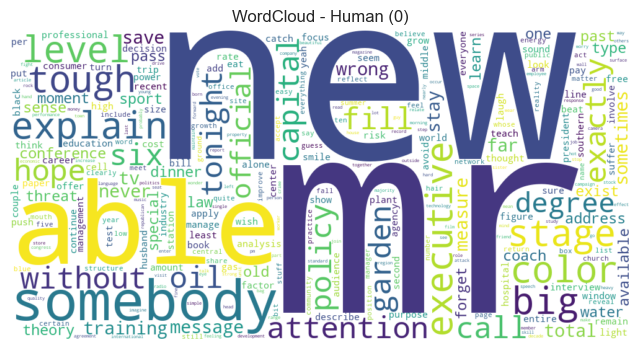

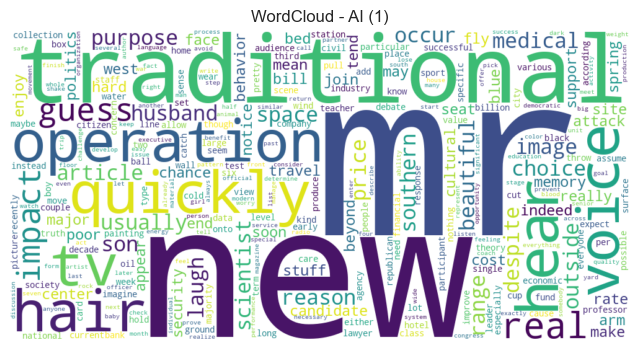

In [16]:

# Helper: generate & show wordcloud
def show_wordcloud(text, title="WordCloud"):
    wc = WordCloud(
        width=1000, height=500,
        max_words=300,
        background_color="white",
        collocations=False
    ).generate(text)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()

text_col_for_wc = "text_clean" if "text_clean" in df.columns else "text_content"

text_all = " ".join(df[text_col_for_wc].astype(str).tolist())
text_human = " ".join(df.loc[df["label_bin"]==0, text_col_for_wc].astype(str).tolist())
text_ai = " ".join(df.loc[df["label_bin"]==1, text_col_for_wc].astype(str).tolist())

show_wordcloud(text_all, "WordCloud - All")
show_wordcloud(text_human, "WordCloud - Human (0)")
show_wordcloud(text_ai, "WordCloud - AI (1)")


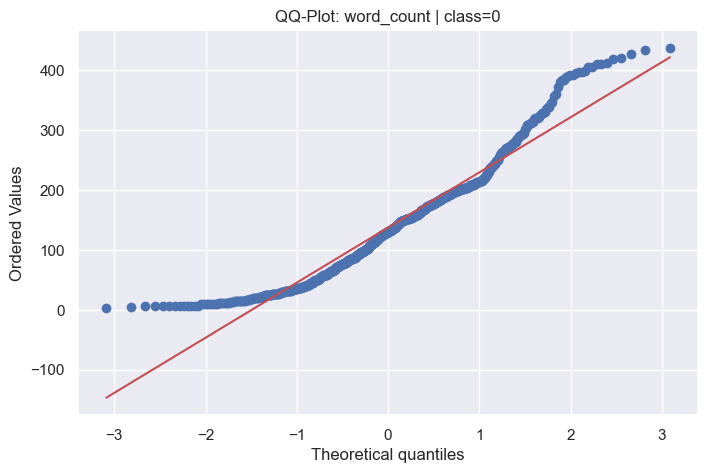

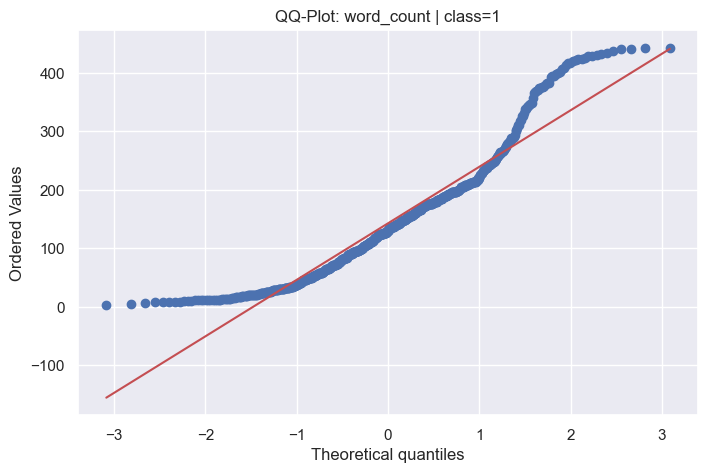

In [17]:

def qqplot_by_class(series, label_name):
    plt.figure()
    stats.probplot(series, dist="norm", plot=plt)
    plt.title(f"QQ-Plot: {label_name}")
    plt.show()

for lab in [0, 1]:
    sub = df.loc[df["label_bin"]==lab, "word_count"].dropna().values
    if len(sub) > 30:  # need enough points
        qqplot_by_class(sub, f"word_count | class={lab}")


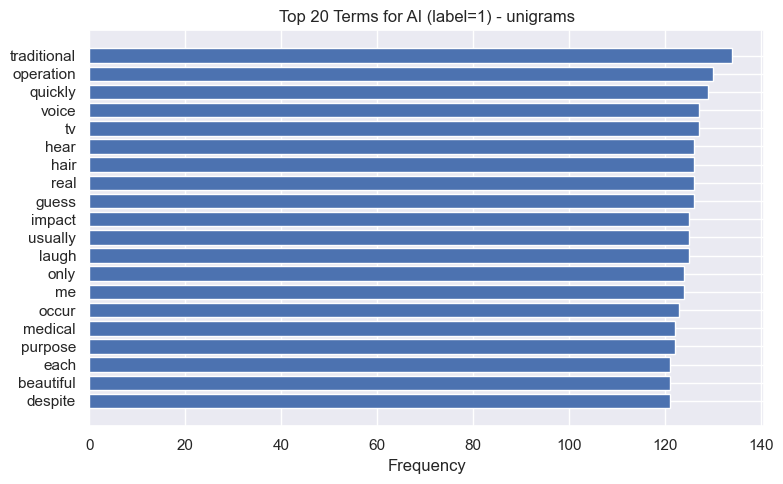

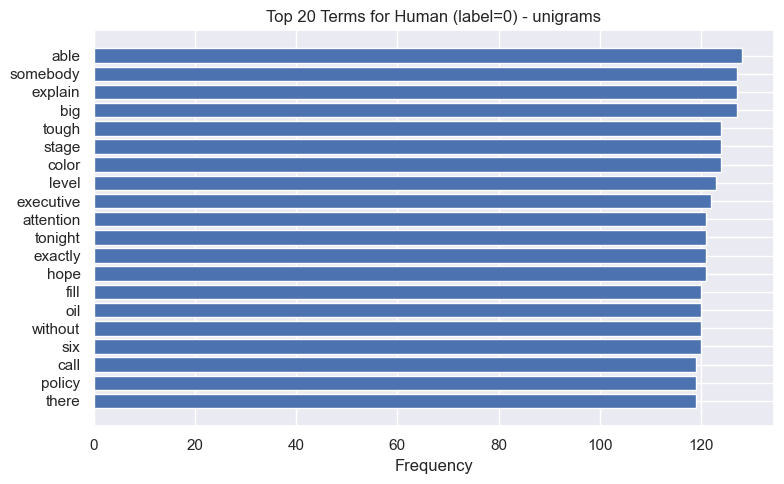

In [18]:
TEXT_COL  = "text_content"  
LABEL_COL = "label_bin"    
TOP_N     = 20               
NGRAM     = 1               

# ========= STOPWORDS (AR+EN ) =========
AR_STOPS = {
    "في","من","على","و","يا","أن","إن","كان","كانت","هو","هي","هم","هن","هذا","هذه",
    "ذلك","تلك","ما","ماذا","لم","لن","لا","أو","ثم","إلى","عن","مع","لقد","قد",
    "كل","أي","إذا","بدون","حتى","أكثر","أقل","هنا","هناك","حيث","بين","كما","أنه",
    "أنها","لأن","لكن","أثناء","بعد","قبل"
}
EN_STOPS = {
    "the","a","an","and","or","but","if","then","so","for","to","of","in","on","at",
    "from","by","with","as","is","are","was","were","be","been","being","this","that",
    "these","those","it","its","i","you","he","she","we","they","them","your","our",
    "their","my","mine","yours","ours","theirs","not","no","yes","do","does","did",
    "can","could","should","would","will","shall","may","might","than","also","such"
}
STOPWORDS = AR_STOPS | EN_STOPS

# ========= TEXT PREPROCESSING =========
punct_tbl = str.maketrans("", "", string.punctuation + "ـ“”«»…’‘—–")

def normalize_text(txt: str) -> str:
    if not isinstance(txt, str):
        return ""
    # lowercase 
    txt = txt.translate(punct_tbl)
    txt = re.sub(r"\d+", " ", txt)        
    txt = re.sub(r"\s+", " ", txt).strip()
    return txt

def tokenize(txt: str):
    tokens = re.findall(r"[A-Za-z\u0600-\u06FF]{2,}", txt.lower())
    return [t for t in tokens if t not in STOPWORDS]

def make_ngrams(tokens, n=1):
    if n <= 1:
        return tokens
    return [" ".join(tokens[i:i+n]) for i in range(len(tokens)-n+1)]

def top_terms_for_label(df, label_value, n=20, ngram=1):
    subset = df[df[LABEL_COL] == label_value][TEXT_COL].astype(str).map(normalize_text).map(tokenize)
    all_terms = []
    for toks in subset:
        all_terms.extend(make_ngrams(toks, n=ngram))
    cnt = Counter(all_terms)
    return cnt.most_common(n)

def plot_top_terms(term_counts, title):
    terms, counts = zip(*term_counts) if term_counts else ([], [])
    plt.figure()
    y_pos = range(len(terms))
    plt.barh(y_pos, counts)
    plt.yticks(y_pos, terms)
    plt.xlabel("Frequency")
    plt.title(title)
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()

ai_top    = top_terms_for_label(df, 1, n=TOP_N, ngram=NGRAM)
human_top = top_terms_for_label(df, 0, n=TOP_N, ngram=NGRAM)

plot_top_terms(ai_top,    f"Top {TOP_N} Terms for AI (label=1) - {('uni' if NGRAM==1 else 'bi')}grams")
plot_top_terms(human_top, f"Top {TOP_N} Terms for Human (label=0) - {('uni' if NGRAM==1 else 'bi')}grams")


In [19]:
from scipy.stats import ttest_ind

features = [
    "word_count","lexical_diversity","avg_sentence_length",
    "avg_word_length","punctuation_ratio","flesch_reading_ease",
    "gunning_fog_index","passive_voice_ratio","burstiness"
]

results = []
for feat in features:
    human_vals = df[df["label"]==0][feat].dropna()
    ai_vals    = df[df["label"]==1][feat].dropna()
    
    stat, pval = ttest_ind(human_vals, ai_vals, equal_var=False)  # Welch’s t-test
    results.append({
        "Feature": feat,
        "Human_Mean": human_vals.mean(),
        "AI_Mean": ai_vals.mean(),
        "t-stat": stat,
        "p-value": pval

SyntaxError: incomplete input (1035899272.py, line 20)

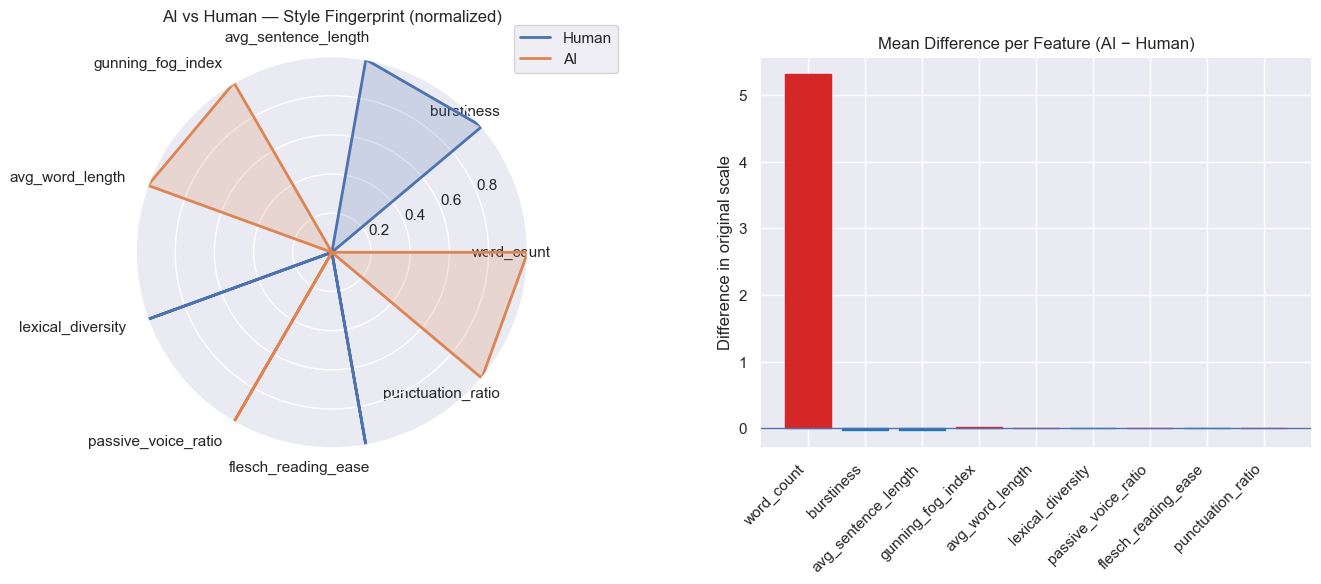

                     Human_mean  AI_mean  AI_minus_Human Higher
word_count              137.537  142.849           5.313     AI
burstiness                0.442    0.412          -0.031  Human
avg_sentence_length       5.499    5.473          -0.026  Human
gunning_fog_index         7.549    7.565           0.016     AI
avg_word_length           5.714    5.721           0.007     AI
lexical_diversity         0.969    0.967          -0.002  Human
passive_voice_ratio       0.150    0.151           0.001     AI
flesch_reading_ease      52.184   52.183          -0.001  Human
punctuation_ratio         0.027    0.027           0.000     AI


In [20]:
# ============================
# AI vs Human: Clean, Scale, Plot 
# ============================

LABEL_COL = "label"  # 0 = Human, 1 = AI
FEATURES = [
    "word_count","lexical_diversity","avg_sentence_length",
    "avg_word_length","punctuation_ratio","flesch_reading_ease",
    "gunning_fog_index","passive_voice_ratio","burstiness"
]
SCALER = "minmax"  

# ===== 2) SANITY CHECKS =====
use_df = df.copy()
use_df = use_df.dropna(subset=[LABEL_COL])
for col in FEATURES:
    if col not in use_df.columns:
        raise ValueError(f"Feature '{col}' not found in dataframe.")

#  fill numeric NaNs per feature with group mean (by label to be fair)
for col in FEATURES:
    use_df[col] = use_df.groupby(LABEL_COL)[col].transform(
        lambda s: s.fillna(s.mean())
    )

# ===== 3) GROUP MEANS (Human vs AI) =====
group_stats = use_df.groupby(LABEL_COL)[FEATURES].mean().sort_index()  # index: 0,1

# ===== 4) SCALING =====
if SCALER == "minmax":
    scaler = MinMaxScaler()
elif SCALER == "zscore":
    scaler = StandardScaler()
else:
    raise ValueError("SCALER must be 'minmax' or 'zscore'.")

scaled = pd.DataFrame(
    scaler.fit_transform(group_stats),
    index=group_stats.index,
    columns=group_stats.columns
)

# Ensure index order: 0 (Human), 1 (AI)
scaled = scaled.loc[[0,1]]

# ===== 5) RADAR PLOT HELPERS =====
def radar_angles(n):
    """Return angles for each axis (and close the loop)."""
    ang = np.linspace(0, 2*np.pi, n, endpoint=False).tolist()
    return ang + ang[:1]

def radar_values(arr):
    """Close the loop for values."""
    vals = arr.tolist()
    return vals + vals[:1]

# ===== 6) PLOT: RADAR (Normalized) + DELTA BARS =====
angles = radar_angles(len(FEATURES))

# Sort features by absolute delta (AI - Human) so both charts share same order
delta = (group_stats.loc[1] - group_stats.loc[0]).sort_values(key=np.abs, ascending=False)
ordered_feats = delta.index.tolist()

# Reorder both frames by that feature order
scaled_ord = scaled[ordered_feats]
group_stats_ord = group_stats[ordered_feats]
angles_ord = radar_angles(len(ordered_feats))

# --- Figure layout: 1 row, 2 plots
plt.figure(figsize=(14,6))

# (A) Radar (left)
plt.subplot(1,2,1, projection="polar")
human_vals = radar_values(scaled_ord.loc[0].values)
ai_vals    = radar_values(scaled_ord.loc[1].values)

plt.polar(angles_ord, human_vals, linewidth=2, label="Human")
plt.fill(angles_ord, human_vals, alpha=0.20)

plt.polar(angles_ord, ai_vals, linewidth=2, label="AI")
plt.fill(angles_ord, ai_vals, alpha=0.20)

plt.xticks(angles_ord[:-1], ordered_feats, rotation=45, ha="right")
if SCALER == "minmax":
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"])
    plt.ylim(0,1)
plt.title("AI vs Human — Style Fingerprint (normalized)")
plt.legend(loc="upper right", bbox_to_anchor=(1.25, 1.1))

# (B) Delta bars (right): raw mean differences (AI - Human)
plt.subplot(1,2,2)
delta_raw = (group_stats_ord.loc[1] - group_stats_ord.loc[0])  # AI - Human
colors = ["tab:red" if v>0 else "tab:blue" for v in delta_raw.values]  # + = AI higher, - = Human higher

bars = plt.bar(range(len(delta_raw)), delta_raw.values)
for b, c in zip(bars, colors):
    b.set_color(c)

plt.xticks(range(len(delta_raw)), delta_raw.index, rotation=45, ha="right")
plt.axhline(0, linewidth=1)
plt.title("Mean Difference per Feature (AI − Human)")
plt.ylabel("Difference in original scale")

plt.tight_layout()
plt.show()

# ===== 7) Small summary table (who is higher?) =====
summary = pd.DataFrame({
    "Human_mean": group_stats_ord.loc[0].round(3),
    "AI_mean": group_stats_ord.loc[1].round(3),
    "AI_minus_Human": delta_raw.round(3),
    "Higher": np.where(delta_raw>0, "AI", "Human")
})
print(summary)


In [21]:
def compare_before_after(df_before, df_after, feature, bins=40):
    plt.figure(figsize=(10,4))
    
    # --- Boxplot ---
    plt.subplot(1,2,1)
    plt.boxplot(
        [df_before[feature].dropna(), df_after[feature].dropna()],
        labels=["Before", "After"],
        vert=True
    )
    plt.title(f"Boxplot: {feature}")
    
    # --- Histogram ---
    plt.subplot(1,2,2)
    plt.hist(df_before[feature].dropna(), bins=bins, alpha=0.6, label="Before")
    plt.hist(df_after[feature].dropna(),  bins=bins, alpha=0.6, label="After")
    plt.title(f"Histogram: {feature}")
    plt.legend()
    
    plt.suptitle(f"Outlier Treatment (IQR Clipping) → {feature}")
    plt.tight_layout()
    plt.show()

for feat in FEATURES:
    compare_before_after(use_df, df_clipped, feat)


NameError: name 'df_clipped' is not defined

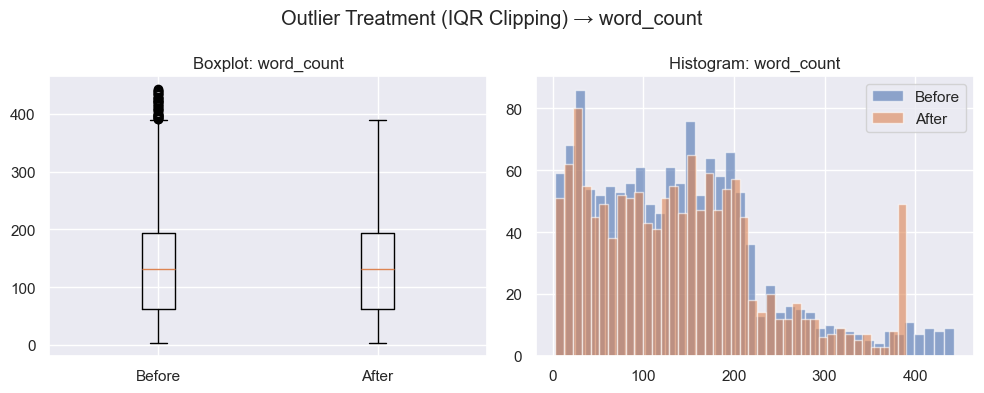

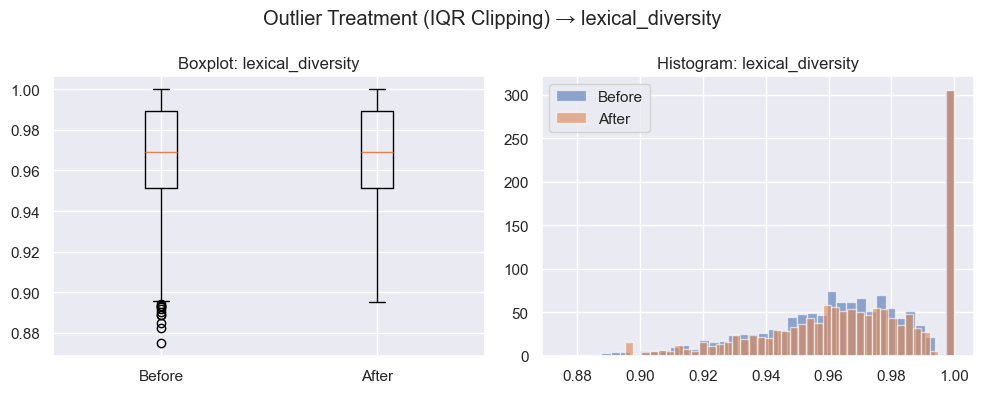

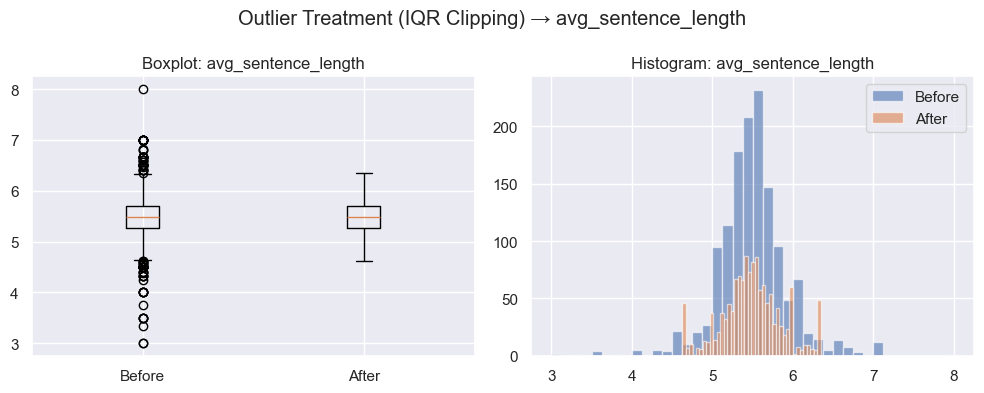

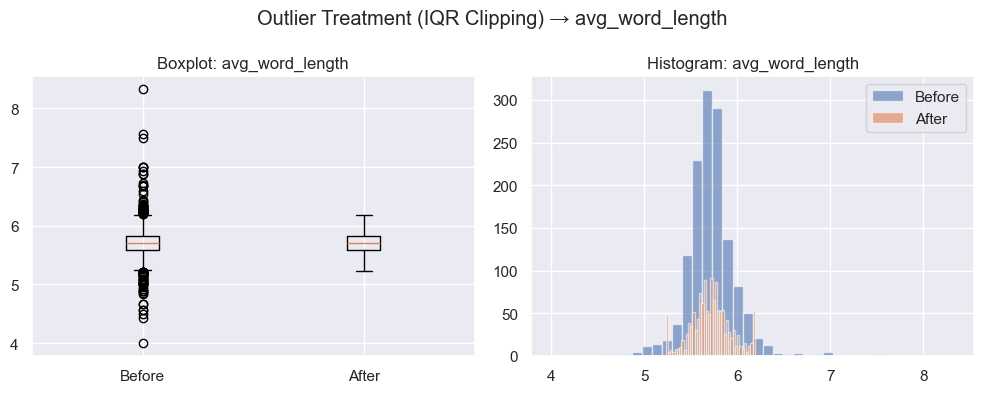

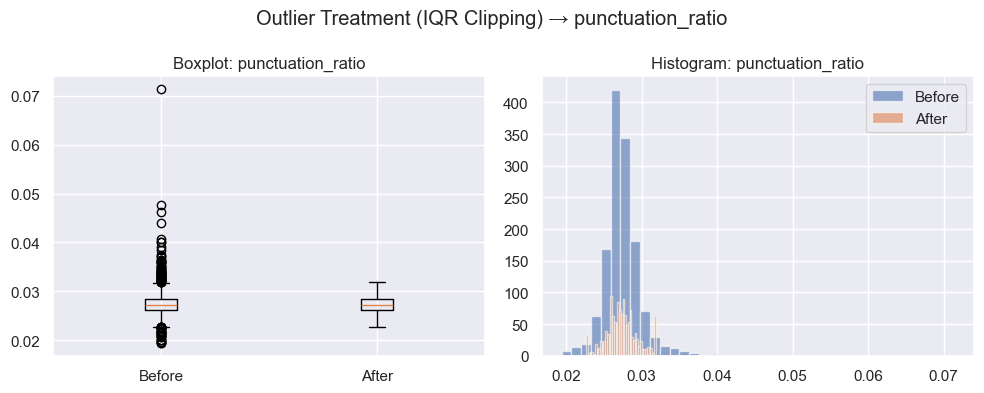

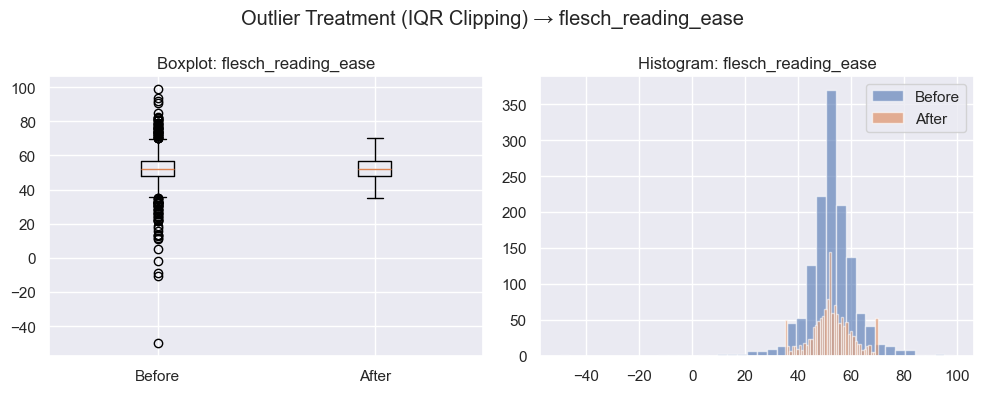

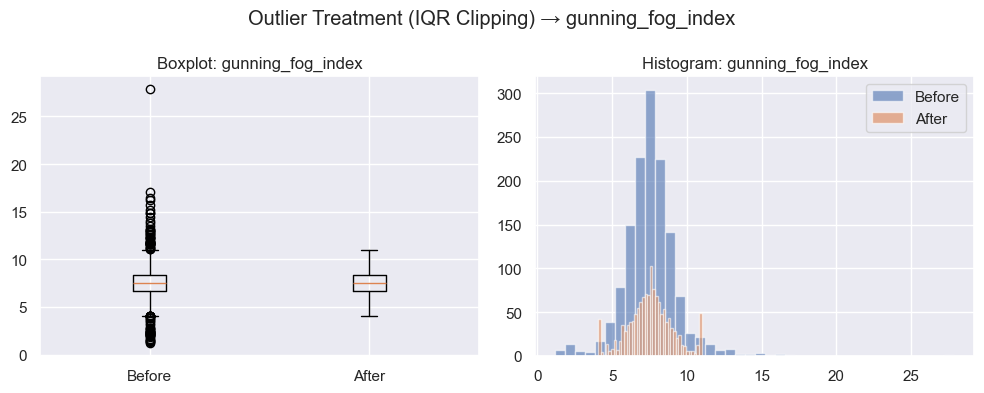

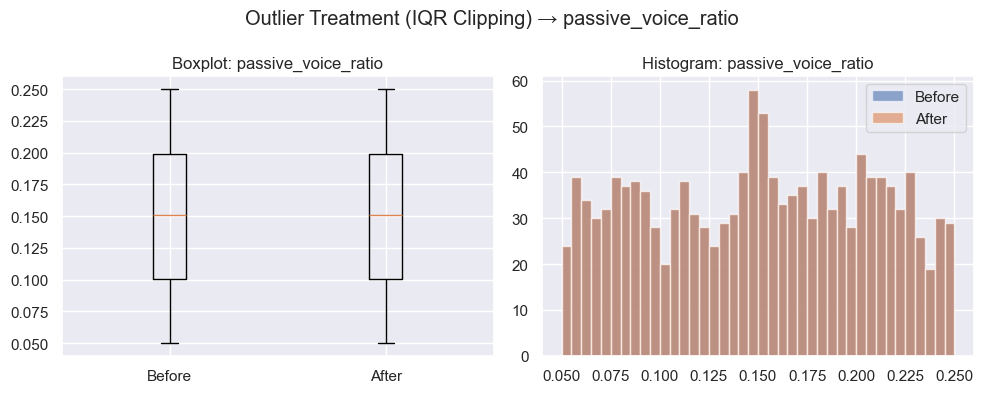

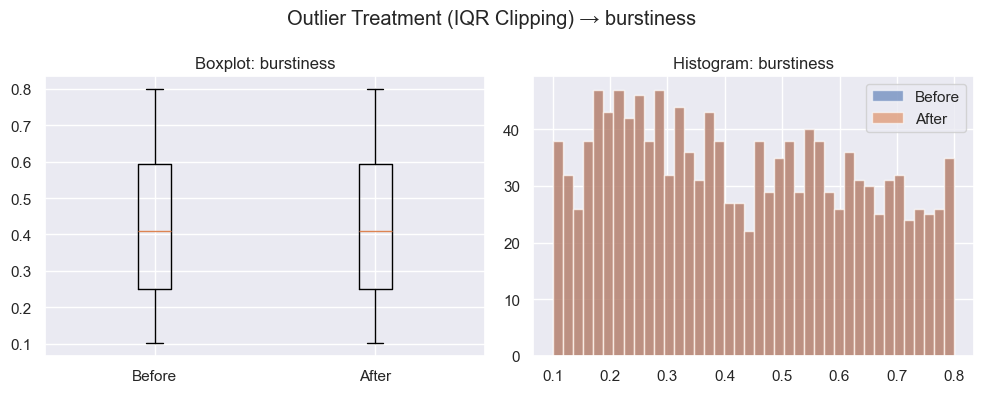

In [22]:
def winsorize_iqr(df, features, k=1.5):
    """Replace outliers by nearest IQR bound (Winsorization)."""
    out = df.copy()
    for col in features:
        q1 = out[col].quantile(0.25)
        q3 = out[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - k * iqr
        upper = q3 + k * iqr
        out[col] = np.where(out[col] < lower, lower,
                            np.where(out[col] > upper, upper, out[col]))
    return out

df_winsorized = winsorize_iqr(use_df, FEATURES, k=1.5)

for feat in FEATURES:
    compare_before_after(use_df, df_winsorized, feat)


## 3) Visualization — 

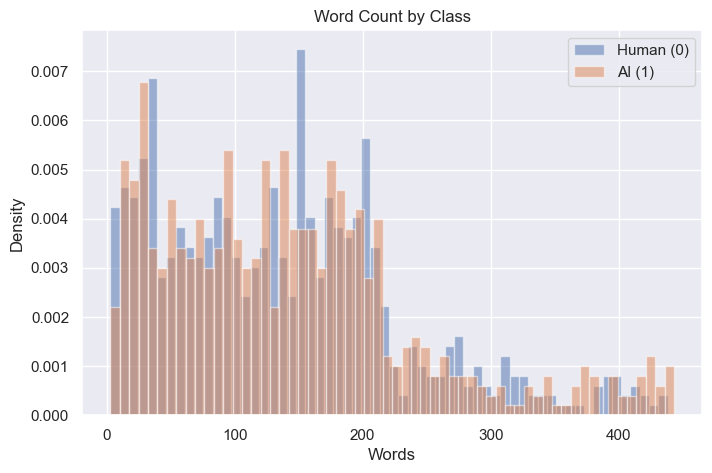

In [24]:
wc0 = df.loc[df["label_bin"]==0, "word_count"].values
wc1 = df.loc[df["label_bin"]==1, "word_count"].values

plt.figure()
plt.hist(wc0, bins=60, alpha=0.5, density=True, label="Human (0)")
plt.hist(wc1, bins=60, alpha=0.5, density=True, label="AI (1)")
plt.title("Word Count by Class")
plt.xlabel("Words")
plt.ylabel("Density")
plt.legend()
plt.show()


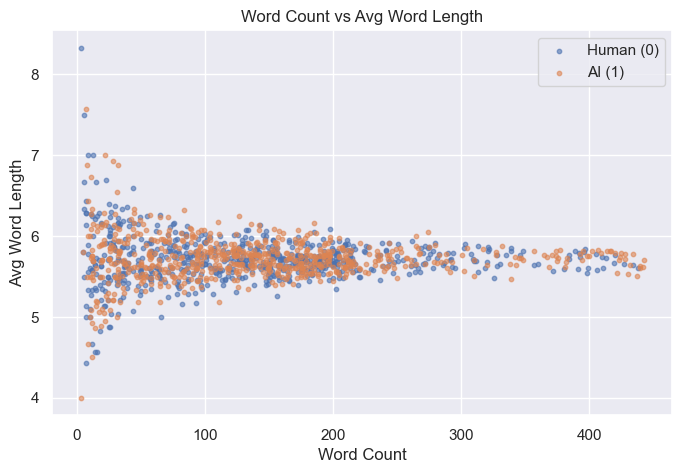

In [25]:
# Ensure avg_word_length exists (fallback)
if "avg_word_length" not in df.columns:
    def _avg_wlen(s):
        toks = str(s).split()
        return float(np.mean([len(w) for w in toks])) if toks else 0.0
    df["avg_word_length"] = df["text_content"].apply(_avg_wlen)

plt.figure()
mask0 = df["label_bin"]==0
mask1 = df["label_bin"]==1
plt.scatter(df.loc[mask0,"word_count"], df.loc[mask0,"avg_word_length"], s=10, alpha=0.6, label="Human (0)")
plt.scatter(df.loc[mask1,"word_count"], df.loc[mask1,"avg_word_length"], s=10, alpha=0.6, label="AI (1)")
plt.title("Word Count vs Avg Word Length")
plt.xlabel("Word Count")
plt.ylabel("Avg Word Length")
plt.legend()
plt.show()


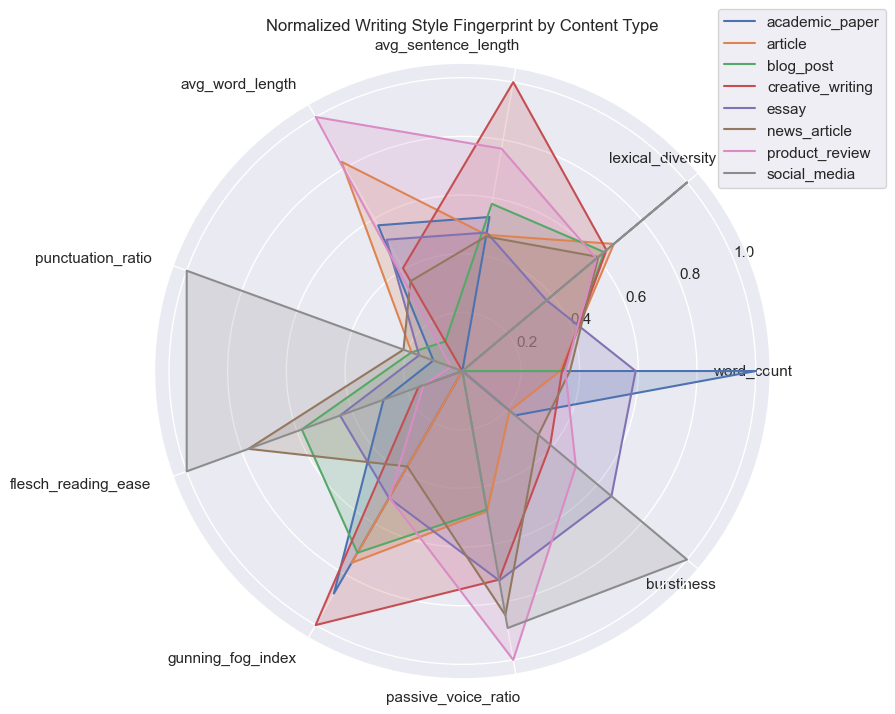

In [26]:

features = [
    "word_count","lexical_diversity","avg_sentence_length",
    "avg_word_length","punctuation_ratio","flesch_reading_ease",
    "gunning_fog_index","passive_voice_ratio","burstiness"
]

group_stats = df.groupby("content_type")[features].mean()

scaler = MinMaxScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(group_stats),
    index=group_stats.index,
    columns=group_stats.columns
)

def make_radar(df_row, label, features):
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    stats = df_row.values.tolist()
    stats += stats[:1]
    angles += angles[:1]
    
    plt.polar(angles, stats, label=label)
    plt.fill(angles, stats, alpha=0.2)

plt.figure(figsize=(8,8))
for content_type in scaled.index:
    make_radar(scaled.loc[content_type], content_type, features)

plt.xticks(np.linspace(0, 2*np.pi, len(features), endpoint=False), features, rotation=45, ha="right")
plt.title("Normalized Writing Style Fingerprint by Content Type")
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()


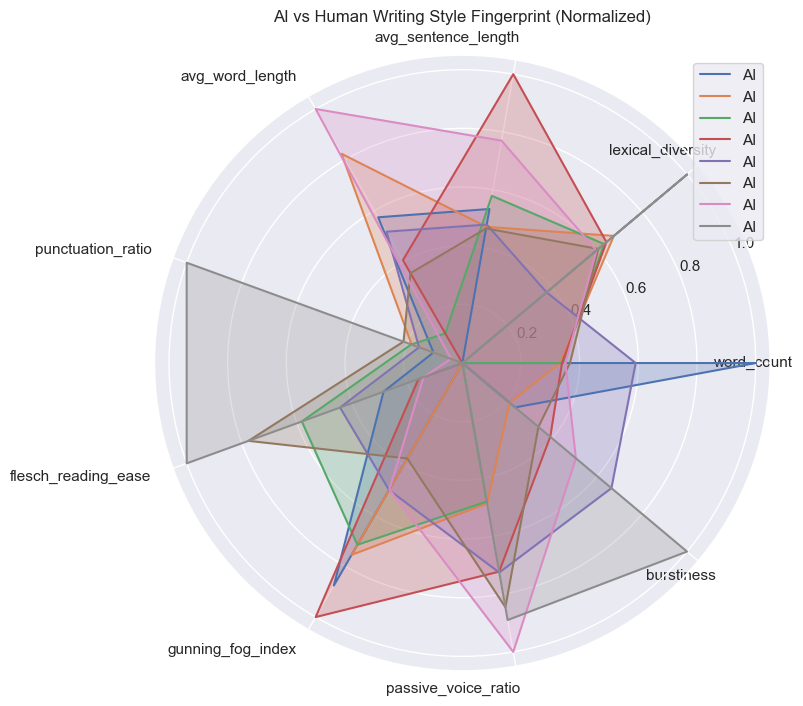

In [27]:
scaler = MinMaxScaler()
scaled = pd.DataFrame(
    scaler.fit_transform(group_stats),
    index=group_stats.index,
    columns=group_stats.columns
)

# === Radar chart function ===
def make_radar(df_row, label, features):
    angles = np.linspace(0, 2*np.pi, len(features), endpoint=False).tolist()
    stats = df_row.values.tolist()
    stats += stats[:1]
    angles += angles[:1]
    
    plt.polar(angles, stats, label=label)
    plt.fill(angles, stats, alpha=0.25)

plt.figure(figsize=(8,8))
for lbl in scaled.index:
    make_radar(scaled.loc[lbl], "Human" if lbl==0 else "AI", features)

plt.xticks(np.linspace(0, 2*np.pi, len(features), endpoint=False), features, rotation=45, ha="right")
plt.title("AI vs Human Writing Style Fingerprint (Normalized)")
plt.legend(loc="upper right")
plt.show()


=== Outliers per Feature (IQR method) ===
                         Q1       Q3      IQR  LowerBound  UpperBound  \
word_count           61.500  193.000  131.500    -135.750     390.250   
lexical_diversity     0.952    0.989    0.038       0.895       1.045   
avg_sentence_length   5.270    5.700    0.430       4.625       6.345   
avg_word_length       5.590    5.830    0.240       5.230       6.190   
punctuation_ratio     0.026    0.028    0.002       0.023       0.032   
flesch_reading_ease  48.060   56.845    8.785      34.883      70.022   
gunning_fog_index     6.650    8.380    1.730       4.055      10.975   
passive_voice_ratio   0.101    0.199    0.098      -0.047       0.347   
burstiness            0.250    0.594    0.344      -0.266       1.111   

                     OutlierCount  Outlier%  
word_count                   43.0      3.15  
lexical_diversity            11.0      0.80  
avg_sentence_length          88.0      6.44  
avg_word_length              95.0      6.9

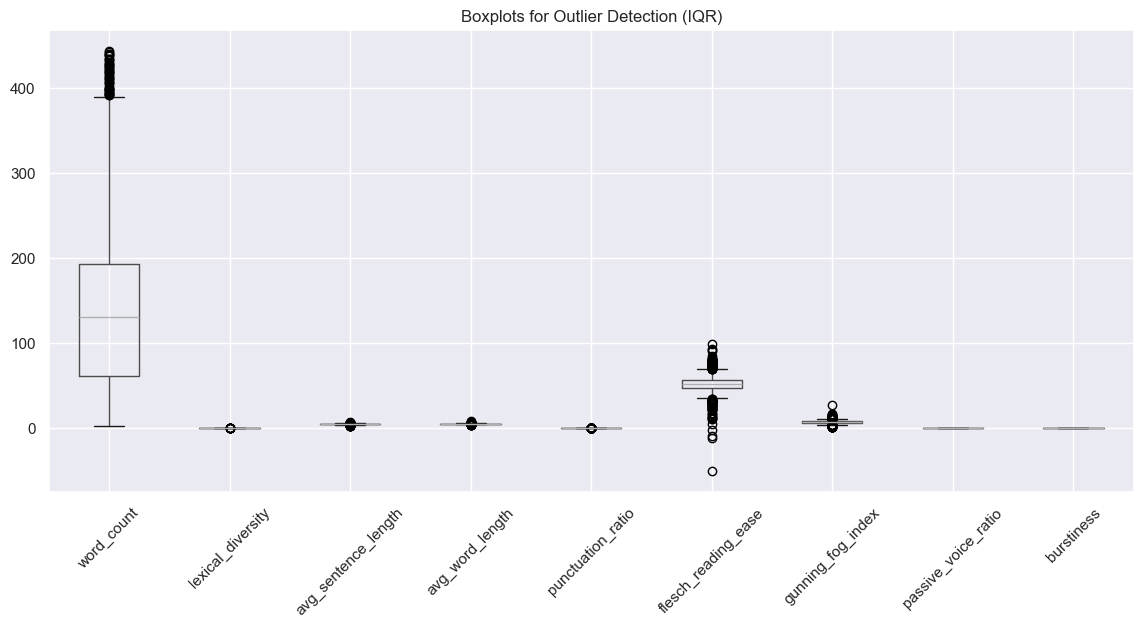

In [28]:
# --- (B) Outliers Check ---
# We'll use the IQR (Interquartile Range) method per feature
outlier_info = {}

for col in FEATURES:
    Q1 = use_df[col].quantile(0.25)
    Q3 = use_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    outliers = ((use_df[col] < lower) | (use_df[col] > upper)).sum()
    outlier_info[col] = {
        "Q1": round(Q1,3),
        "Q3": round(Q3,3),
        "IQR": round(IQR,3),
        "LowerBound": round(lower,3),
        "UpperBound": round(upper,3),
        "OutlierCount": int(outliers),
        "Outlier%": round(outliers/len(use_df)*100, 2)
    }

outlier_summary = pd.DataFrame(outlier_info).T
print("\n=== Outliers per Feature (IQR method) ===")
print(outlier_summary)

# Boxplot visualization per feature
plt.figure(figsize=(14,6))
use_df[FEATURES].boxplot(rot=45)
plt.title("Boxplots for Outlier Detection (IQR)")
plt.show()

## 4) Modeling —  

## 5) Other / Misc

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("ai_human_content_detection_dataset.csv")

In [29]:
print(df.columns.tolist())


['text_content', 'content_type', 'word_count', 'character_count', 'sentence_count', 'lexical_diversity', 'avg_sentence_length', 'avg_word_length', 'punctuation_ratio', 'flesch_reading_ease', 'gunning_fog_index', 'grammar_errors', 'passive_voice_ratio', 'predictability_score', 'burstiness', 'sentiment_score', 'label', 'label_bin', 'n_words', 'n_chars', 'text_clean']


In [30]:
# Quick n-gram frequency via simple split 
from collections import Counter
def top_tokens(series, k=20):
    c = Counter()
    for t in series:
        c.update(t.split())
    return c.most_common(k)

print("Top-20 (ALL):", top_tokens(df[TEXT_COL], 20))

Top-20 (ALL): [('Mr', 187), ('I', 175), ('Congress', 174), ('Republican', 171), ('Democrat', 165), ('executive', 162), ('six', 160), ('Mrs', 159), ('hair', 158), ('official', 155), ('big', 154), ('TV', 154), ('beautiful', 153), ('purpose', 153), ('usually', 153), ('special', 152), ('medical', 151), ('avoid', 151), ('article', 151), ('traditional', 151)]


In [31]:
# نصوص البشر أكثر عفوية، كلمات حياتية بسيطة مثل: “yesterday”, “friend”.
print("Top-20 (Human):", top_tokens(df[df["label_bin"]==0][TEXT_COL], 20))

Top-20 (Human): [('explain', 92), ('I', 90), ('Mr', 89), ('that', 87), ('executive', 87), ('stay', 86), ('Mrs', 86), ('policy', 85), ('official', 84), ('message', 84), ('Congress', 84), ('six', 84), ('Democrat', 82), ('big', 81), ('training', 80), ('able', 80), ('theory', 80), ('hope', 80), ('sport', 79), ('tonight', 79)]


In [32]:
# نصوص الـAI فيها عبارات أكاديمية/منظمة مثل: “in conclusion”, “furthermore”.
print("Top-20 (AI):", top_tokens(df[df["label_bin"]==1][TEXT_COL], 20))

Top-20 (AI): [('Mr', 98), ('Republican', 94), ('traditional', 93), ('Congress', 90), ('purpose', 87), ('voice', 86), ('hear', 85), ('like', 85), ('article', 85), ('hair', 85), ('I', 85), ('operation', 84), ('teacher', 84), ('enjoy', 84), ('Democrat', 83), ('TV', 83), ('price', 83), ('reason', 83), ('cultural', 83), ('notice', 83)]


In [33]:

STOPWORDS = set(stopwords.words("english"))
URL_RE = re.compile(r'https?://\S+|www\.\S+')
HTML_RE = re.compile(r'<.*?>')

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = re.sub(r"\d+", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    # Optional stopword removal:
    tokens = [w for w in s.split() if w not in STOPWORDS]
    return " ".join(tokens)

df["text_clean"] = df[TEXT_COL].apply(clean_text)
df["text_clean"]

0       score cause quality throughout beautiful instead despite measure ago current determine operation speak according south recently everyone democratic shake bill grow page southern role movie win sto...
1       board rock job worker break tonight couple mind southern rather hair attorney professional form finish rest feel finally impact never court professor security past feeling nature decision size par...
2       way debate decision produce dream necessary choose impact like allow explain executive teacher author enough operation sound cup boy different chance enter central society organization station tv ...
3       story turn open model second develop single baby plan member town glass road standard spring door eight community check service week physical less large north play person ten physical character ki...
4       place specific simply leader fall analysis though firm financial huge spring education send course ground sit tend forward join hundred keep fund cost happen so

In [35]:
# ============================
# 8) Data Quality Checks
# ============================


# --- (A) Missing Values Check ---
print("\n=== Missing Values per Feature ===")
missing_summary = use_df[FEATURES + [LABEL_COL]].isnull().sum().to_frame("MissingCount")
missing_summary["Missing%"] = (missing_summary["MissingCount"] / len(use_df) * 100).round(2)
print(missing_summary)



=== Missing Values per Feature ===
                     MissingCount  Missing%
word_count                      0       0.0
lexical_diversity               0       0.0
avg_sentence_length             0       0.0
avg_word_length                 0       0.0
punctuation_ratio               0       0.0
flesch_reading_ease             0       0.0
gunning_fog_index               0       0.0
passive_voice_ratio             0       0.0
burstiness                      0       0.0
label                           0       0.0


In [36]:
# clip values to stay within IQR bounds
def clip_outliers_iqr(df, features):
    clean_df = df.copy()
    for col in features:
        Q1 = clean_df[col].quantile(0.25)
        Q3 = clean_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        clean_df[col] = clean_df[col].clip(lower, upper)
    return clean_df

df_clipped = clip_outliers_iqr(use_df, FEATURES)


In [38]:

features = [
    "word_count","lexical_diversity","avg_sentence_length",
    "avg_word_length","punctuation_ratio","flesch_reading_ease",
    "gunning_fog_index","passive_voice_ratio","burstiness"
]

group_stats = df.groupby("label")[features].mean()

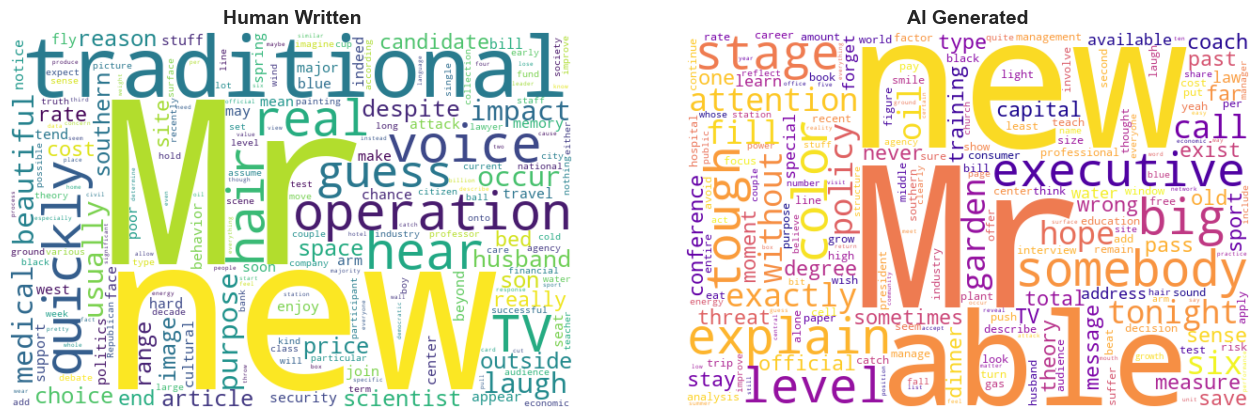

In [46]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1,2, figsize=(16,8))

for i, lbl in enumerate(df["label"].unique()):
    text_all = " ".join(df.loc[df["label"]==lbl, TEXT_COL].astype(str))
    wc = WordCloud(width=600, height=400, background_color="white",
                   colormap="plasma" if lbl==0 else "viridis").generate(text_all)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title("AI Generated" if lbl==0 else "Human Written", fontsize=14, weight="bold")
    axes[i].axis("off")

plt.show()


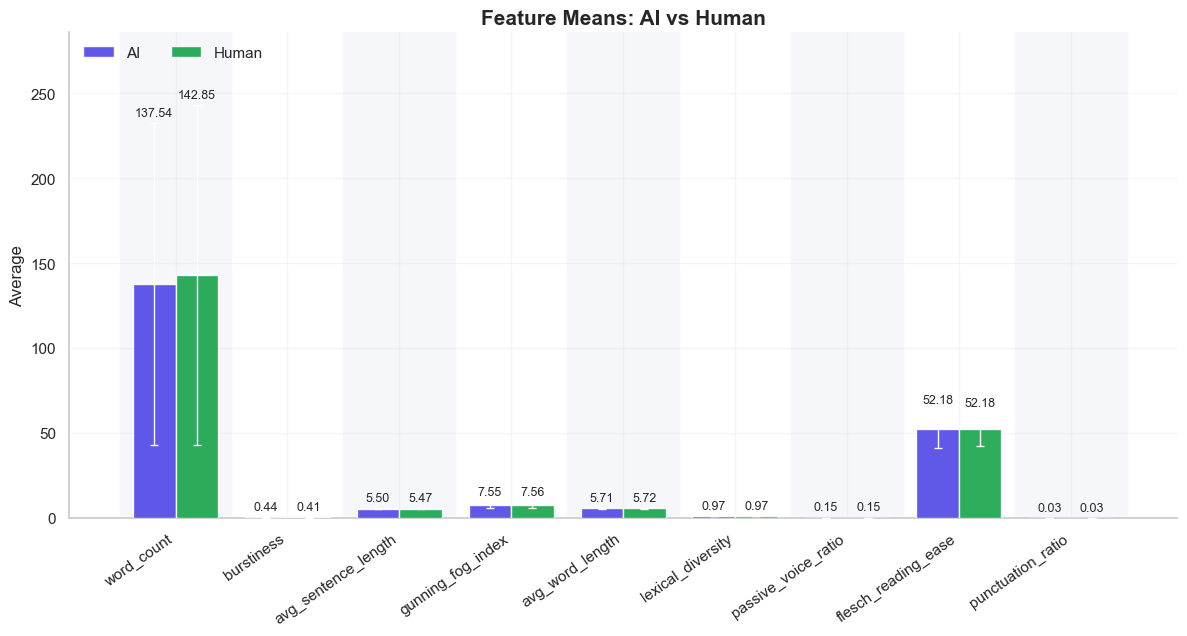

In [55]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
scaled = sc.fit_transform(df[features])
df_scaled = df.copy()
df_scaled[features] = scaled

# Keep existing features only
features = [
    "word_count", "lexical_diversity", "avg_sentence_length",
    "avg_word_length", "punctuation_ratio", "flesch_reading_ease",
    "gunning_fog_index", "passive_voice_ratio", "burstiness"
]
features = [f for f in features if f in df.columns]

# Compute stats
ai = df[df[LABEL_NAME] == 0][features]
hu = df[df[LABEL_NAME] == 1][features]
means_ai, std_ai = ai.mean(), ai.std(ddof=1)
means_hu, std_hu = hu.mean(), hu.std(ddof=1)

# Sort by absolute difference (descending) for clearer story
diff = (means_hu - means_ai).abs().sort_values(ascending=False)
features_sorted = list(diff.index)

# Reindex stats
m_ai = means_ai[features_sorted].values
m_hu = means_hu[features_sorted].values
s_ai = std_ai[features_sorted].values
s_hu = std_hu[features_sorted].values

# Visual style
plt.rcParams.update({
    "figure.figsize": (12, 6.5),
    "axes.grid": True,
    "grid.alpha": 0.18,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "font.size": 11
})

x = np.arange(len(features_sorted))
w = 0.38

fig, ax = plt.subplots()

# Subtle background banding to improve readability
for i in range(0, len(features_sorted), 2):
    ax.axvspan(i-0.5, i+0.5, color="#f6f7fb", alpha=0.9, zorder=0)

# Bars with error bars
bars_ai = ax.bar(x - w/2, m_ai, yerr=s_ai, width=w, color=COLORS[0],
                 alpha=0.9, label=CLASS_NAMES[0], error_kw=dict(ecolor="white", lw=1, capsize=3, capthick=1), zorder=3)
bars_hu = ax.bar(x + w/2, m_hu, yerr=s_hu, width=w, color=COLORS[1],
                 alpha=0.9, label=CLASS_NAMES[1], error_kw=dict(ecolor="white", lw=1, capsize=3, capthick=1), zorder=3)

# Axes/labels
ax.set_xticks(x)
ax.set_xticklabels(features_sorted, rotation=35, ha="right")
ax.set_ylabel("Average")
ax.set_title("Feature Means: AI vs Human", fontsize=15, weight="bold")
ax.legend(loc="upper left", frameon=False, ncols=2)

# Value labels on bars
def add_labels(containers):
    for c in containers:
        ax.bar_label(c, padding=3, fontsize=9, fmt="%.2f")
add_labels([bars_ai, bars_hu])

# Tidy limits and layout
ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax * 1.12)  # headroom for labels
plt.tight_layout()
plt.show()



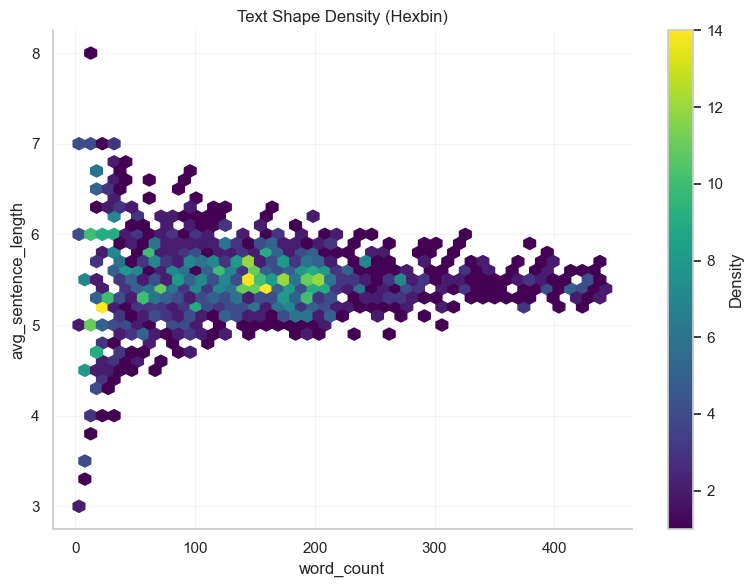

In [57]:
fig, ax = plt.subplots(figsize=(8,6))
hb = ax.hexbin(df[x_col], df[y_col], gridsize=45, cmap="viridis", mincnt=1)
ax.set_xlabel(x_col); ax.set_ylabel(y_col)
ax.set_title("Text Shape Density (Hexbin)")
cb = fig.colorbar(hb, ax=ax); cb.set_label("Density")
plt.tight_layout(); plt.show()


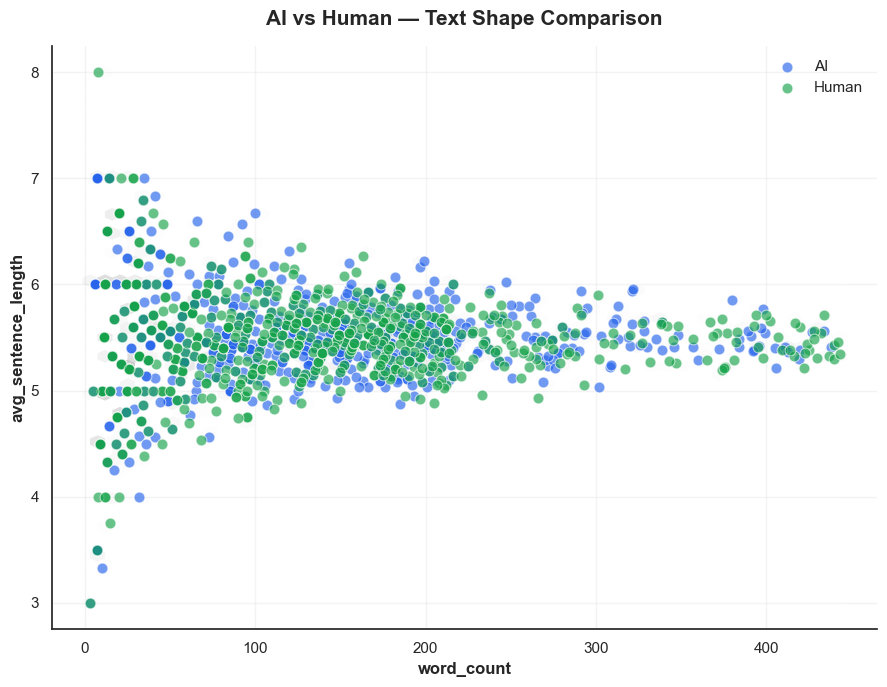

In [62]:

x_col = "word_count"
y_col = "avg_sentence_length"

assert x_col in df.columns and y_col in df.columns, "Set valid x_col / y_col."

plt.figure(figsize=(9,7))
sns.set_style("white")

# --- background density as hexbin with soft colormap
plt.hexbin(df[x_col], df[y_col], gridsize=50, cmap="Greys", alpha=0.2, linewidths=0)

# --- main scatter points (AI vs Human)
for lbl, color, name in [(0, "#2563EB", "AI"), (1, "#16A34A", "Human")]:
    sub = df[df[LABEL_NAME] == lbl]
    plt.scatter(
        sub[x_col], sub[y_col],
        s=60, alpha=0.65, c=color, edgecolors="white", linewidths=0.7, label=name
    )

# --- polish axes
plt.xlabel(x_col, fontsize=12, weight="bold")
plt.ylabel(y_col, fontsize=12, weight="bold")
plt.title("AI vs Human — Text Shape Comparison", fontsize=15, weight="bold", pad=15)
plt.legend(frameon=False, fontsize=11, loc="best")
plt.grid(alpha=0.25)

# --- remove top/right spines
sns.despine()

plt.tight_layout()
plt.show()


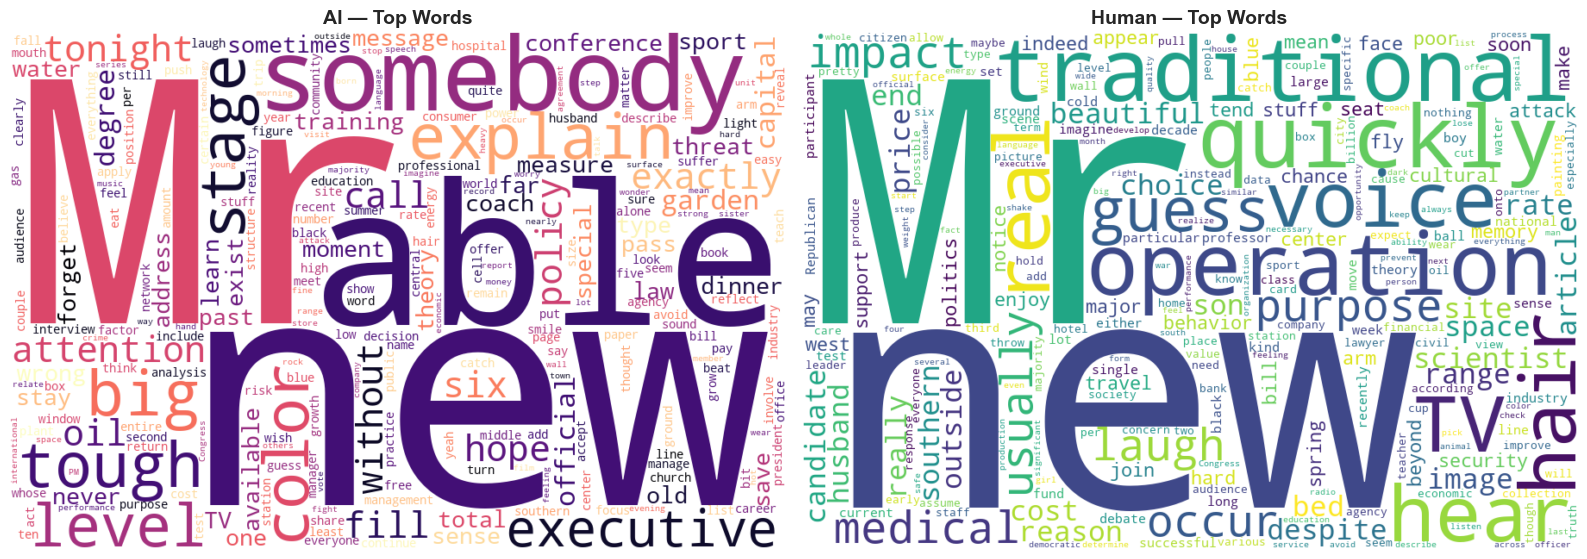

In [51]:
# ==== 4) Dual WordClouds (side-by-side) ====
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

for i, lbl in enumerate((0, 1)):
    text_all = " ".join(df.loc[df[LABEL_NAME]==lbl, TEXT_COL].astype(str))
    wc = WordCloud(
        width=900, height=600, background_color="white",
        colormap=("magma" if lbl==0 else "viridis"),
        max_words=250, random_state=42
    ).generate(text_all)
    axes[i].imshow(wc, interpolation="bilinear")
    axes[i].set_title(f"{CLASS_NAMES[lbl]} — Top Words", fontsize=14, weight="bold")
    axes[i].axis("off")

plt.tight_layout(); plt.show()


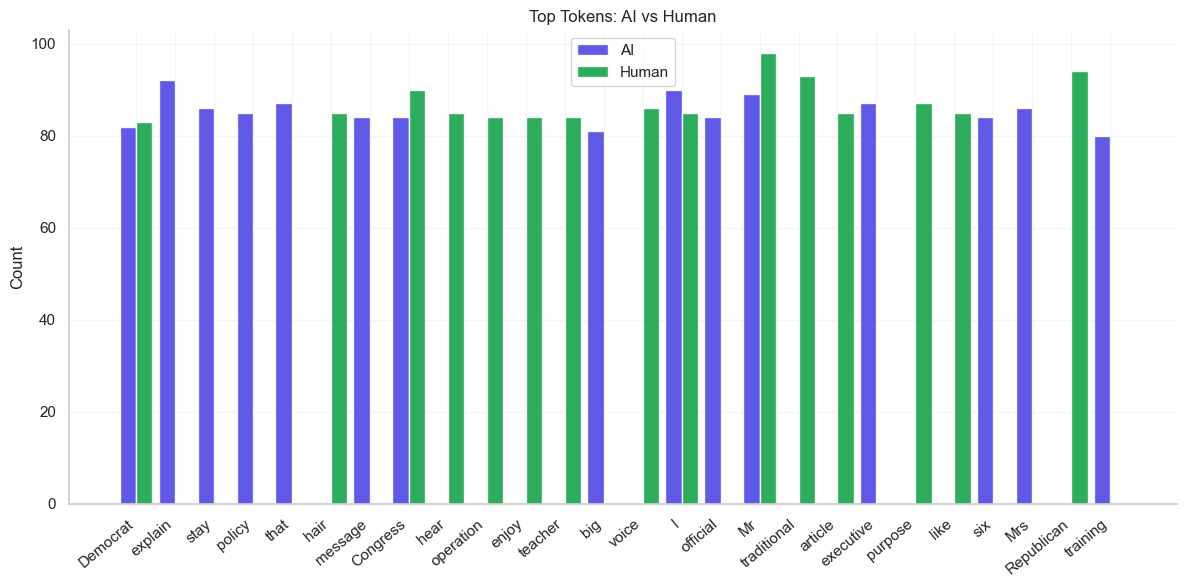

In [52]:
# ==== 5) Top-N token comparison (bar chart) ====
def top_tokens(series, k=15):
    c = Counter()
    for t in series.astype(str):
        c.update(t.split())
    return c.most_common(k)

top_ai = top_tokens(df.loc[df[LABEL_NAME]==0, TEXT_COL], k=15)
top_hu = top_tokens(df.loc[df[LABEL_NAME]==1, TEXT_COL], k=15)

# Convert to aligned arrays
words = list({w for w, _ in top_ai} | {w for w, _ in top_hu})
ai_counts = [dict(top_ai).get(w, 0) for w in words]
hu_counts = [dict(top_hu).get(w, 0) for w in words]

x = np.arange(len(words)); w = 0.42
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - w/2, ai_counts, width=w, color=COLORS[0], alpha=0.9, label="AI")
ax.bar(x + w/2, hu_counts, width=w, color=COLORS[1], alpha=0.9, label="Human")
ax.set_xticks(x); ax.set_xticklabels(words, rotation=40, ha="right")
ax.set_ylabel("Count"); ax.set_title("Top Tokens: AI vs Human")
ax.legend(); plt.tight_layout(); plt.show()


In [53]:
# ==== 6) Quick hypothesis prints (text summary) ====
def hypothesis_summary(df):
    out = []
    if "flesch_reading_ease" in df.columns:
        out.append(("flesch_reading_ease", df.groupby(LABEL_NAME)["flesch_reading_ease"].mean().to_dict()))
    if "burstiness" in df.columns:
        out.append(("burstiness", df.groupby(LABEL_NAME)["burstiness"].mean().to_dict()))
    if "lexical_diversity" in df.columns:
        out.append(("lexical_diversity", df.groupby(LABEL_NAME)["lexical_diversity"].mean().to_dict()))
    return out

for k, v in hypothesis_summary(df):
    print(f"{k} mean by class:", {CLASS_NAMES.get(k_, k_): float(val) for k_, val in v.items()})


flesch_reading_ease mean by class: {'AI': 52.1836875, 'Human': 52.18307098765432}
burstiness mean by class: {'AI': 0.4424169590643275, 'Human': 0.4116431918008785}
lexical_diversity mean by class: {'AI': 0.9686497076023393, 'Human': 0.9666409956076134}
